In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import random
import xgboost as xgb
from imblearn.over_sampling import SMOTEN
from collections import Counter

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, roc_auc_score, roc_curve, precision_score, precision_recall_curve, roc_auc_score, roc_curve, f1_score, accuracy_score, recall_score, average_precision_score, mean_squared_error, r2_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans

In [3]:
pd.set_option('display.max_columns', None)
np.random.seed(1973) 

In [9]:
df = pd.read_csv(r"C:\Users\xtaym\OneDrive\Pulpit\mgr\cell2celltrain.csv")
# holdout_innit = pd.read_csv(r""C:\Users\xtaym\OneDrive\Pulpit\cell2cell-duke univeristy.csv"mgr\cell2cellholdout.csv")
# df=pd.read_csv(r'C:\Users\xtaym\OneDrive\Pulpit\cell2cell-duke univeristy.csv')

df 

,CustomerID,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,BlockedCalls,UnansweredCalls,CustomerCareCalls,ThreewayCalls,ReceivedCalls,OutboundCalls,InboundCalls,PeakCallsInOut,OffPeakCallsInOut,DroppedBlockedCalls,CallForwardingCalls,CallWaitingCalls,MonthsInService,UniqueSubs,ActiveSubs,ServiceArea,Handsets,HandsetModels,CurrentEquipmentDays,AgeHH1,AgeHH2,ChildrenInHH,HandsetRefurbished,HandsetWebCapable,TruckOwner,RVOwner,Homeownership,BuysViaMailOrder,RespondsToMailOffers,OptOutMailings,NonUSTravel,OwnsComputer,HasCreditCard,RetentionCalls,RetentionOffersAccepted,NewCellphoneUser,NotNewCellphoneUser,ReferralsMadeBySubscriber,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus
0,3000002,Yes,24.00,219.0,22.0,0.25,0.0,0.0,-157.0,-19.0,0.7,0.7,6.3,0.0,0.0,97.2,0.0,0.0,58.0,24.0,1.3,0.0,0.3,61,2,1,SEAPOR503,2.0,2.0,361.0,62.0,0.0,No,No,Yes,No,No,Known,Yes,Yes,No,No,Yes,Yes,1,0,No,No,0,4,No,0,30,Yes,1-Highest,Suburban,Professional,No
1,3000010,Yes,16.99,10.0,17.0,0.00,0.0,0.0,-4.0,0.0,0.3,0.0,2.7,0.0,0.0,0.0,0.0,0.0,5.0,1.0,0.3,0.0,0.0,58,1,1,PITHOM412,2.0,1.0,1504.0,40.0,42.0,Yes,No,No,No,No,Known,Yes,Yes,No,No,Yes,Yes,0,0,Yes,No,0,5,No,0,30,No,4-Medium,Suburban,Professional,Yes
2,3000014,No,38.00,8.0,38.0,0.00,0.0,0.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.3,0.0,1.3,3.7,0.0,0.0,0.0,60,1,1,MILMIL414,1.0,1.0,1812.0,26.0,26.0,Yes,No,No,No,No,Unknown,No,No,No,No,No,Yes,0,0,Yes,No,0,6,No,0,Unknown,No,3-Good,Town,Crafts,Yes
3,3000022,No,82.28,1312.0,75.0,1.24,0.0,0.0,157.0,8.1,52.0,7.7,76.0,4.3,1.3,200.3,370.3,147.0,555.7,303.7,59.7,0.0,22.7,59,2,2,PITHOM412,9.0,4.0,458.0,30.0,0.0,No,No,Yes,No,No,Known,Yes,Yes,No,No,No,Yes,0,0,Yes,No,0,6,No,0,10,No,4-Medium,Other,Other,No
4,3000026,Yes,17.14,0.0,17.0,0.00,0.0,0.0,0.0,-0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53,2,2,OKCTUL918,4.0,3.0,852.0,46.0,54.0,No,No,No,No,No,Known,Yes,Yes,No,No,Yes,Yes,0,0,No,Yes,0,9,No,1,10,No,1-Highest,Other,Professional,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51042,3399958,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.3,2.7,48.3,0.0,0.0,58.9,17.0,1.3,160.3,33.3,12.0,0.0,0.3,29,1,1,LAXSFN818,2.0,2.0,526.0,68.0,64.0,No,Yes,Yes,No,No,Known,Yes,Yes,No,No,No,Yes,0,0,No,No,0,6,No,0,60,No,1-Highest,Suburban,Other,Yes
51043,3399974,No,95.17,1745.0,85.0,0.99,45.0,4.7,122.0,15.9,16.7,0.7,41.3,0.0,0.0,681.5,89.7,33.3,318.7,248.3,17.3,0.0,14.3,29,1,1,LAXCDG310,2.0,2.0,464.0,48.0,48.0,Yes,No,Yes,No,No,Known,Yes,Yes,No,No,Yes,Yes,0,0,No,No,0,9,No,1,60,No,3-Good,Other,Other,No
51044,3399978,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.7,4.3,287.0,1.3,13.7,1225.3,430.3,87.7,1359.0,910.3,76.0,0.0,6.7,25,1,1,LAXCDG310,3.0,2.0,378.0,36.0,0.0,No,No,Yes,No,No,Known,No,No,No,No,No,Yes,0,0,No,No,0,7,No,1,80,No,5-Low,Other,Clerical,No
51045,3399990,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31,1,1,NEVPOW619,2.0,2.0,433.0,32.0,0.0,Yes,No,Yes,No,No,Unknown,No,No,No,No,No,No,0,0,No,No,0,9,No,0,30,No,5-Low,Other,Other,No


In [10]:
df['Churn'].value_counts()

Churn
No     36336
Yes    14711
Name: count, dtype: int64

In [11]:
df=df.dropna()

In [13]:
df=df.drop(columns=['CustomerID','ServiceArea'])

In [14]:
df=pd.get_dummies(df)

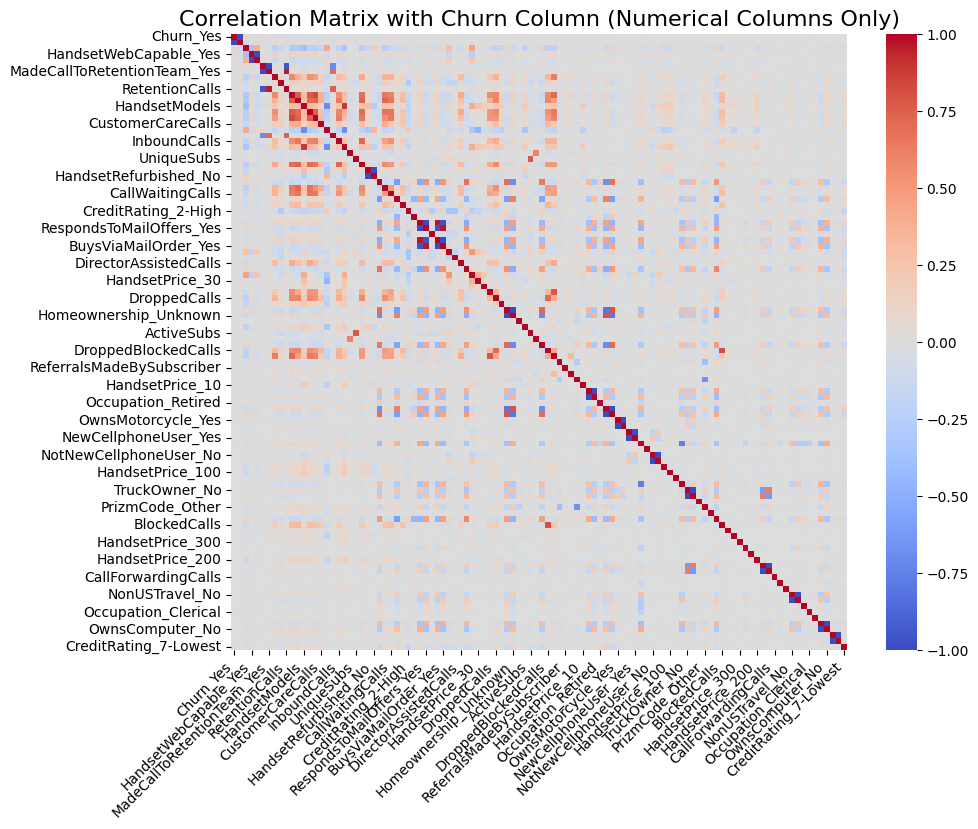

In [23]:
corr_matrix = df.corr()

# Extract the correlations involving the churn column (assuming 'churn_label_Yes' is in numerical_cols)
columns_of_interest = corr_matrix['Churn_Yes'].abs().sort_values(ascending=False).index
selected_corr_matrix = corr_matrix.loc[columns_of_interest, columns_of_interest]

# Plot the correlation matrix with variable labels but no axis labels
plt.figure(figsize=(10, 8))
sns.heatmap(selected_corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1, cbar=True, square=True)

# Remove axis labels but keep the variable labels
plt.title('Correlation Matrix with Churn Column (Numerical Columns Only)', fontsize=16)
plt.xlabel('')
plt.ylabel('')

# Adjust tick labels
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.show()

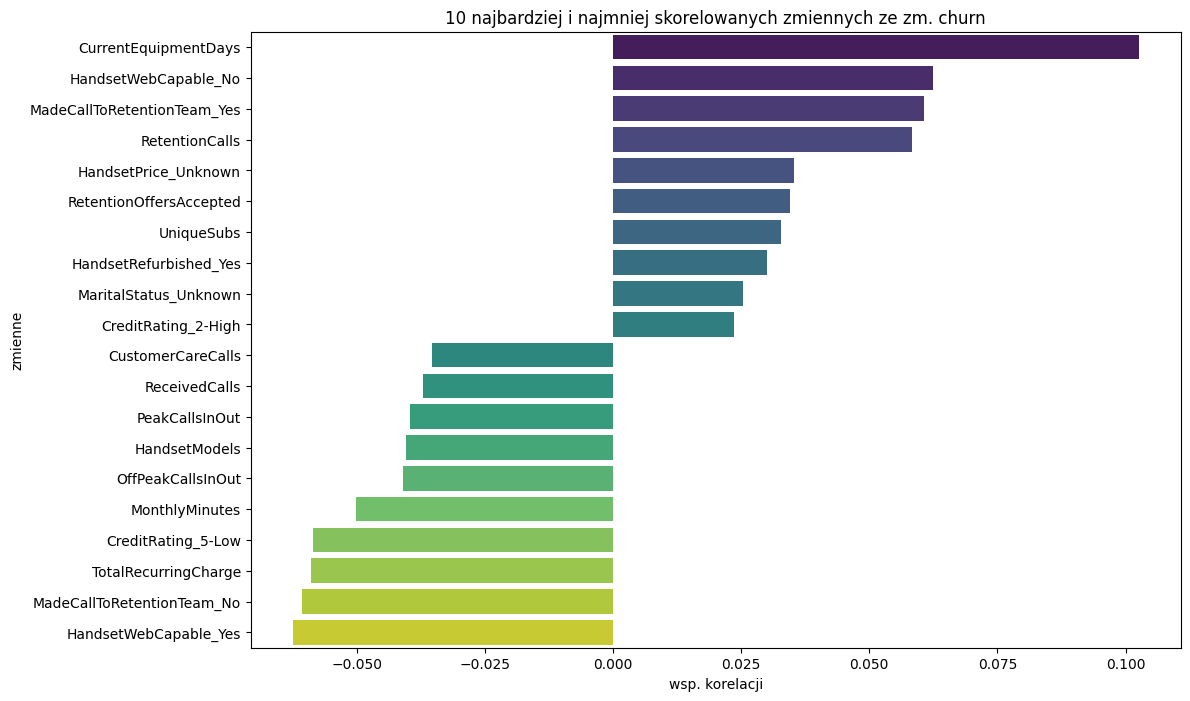

In [28]:
correlation_matrix = df.drop(columns='Churn_No').corr()
# correlation_matrix=correlation_matrix.drop(columns='Churn_No')
churn_correlation = correlation_matrix['Churn_Yes'].sort_values()
# churn_correlation = churn_correlation.drop(columns='Churn_No')
most_correlated = churn_correlation.tail(11).head(10)  # Exclude the 'Churn' correlation with itself
least_correlated = churn_correlation.head(10)
combined_correlations = pd.concat([most_correlated, least_correlated]).sort_values(ascending=False)


plt.figure(figsize=(12, 8))
sns.barplot(x=combined_correlations.values, y=combined_correlations.index, palette='viridis')
plt.title('10 najbardziej i najmniej skorelowanych zmiennych ze zm. churn')
plt.xlabel('wsp. korelacji')
plt.ylabel('zmienne')
plt.show()

In [47]:
y=df.Churn_Yes
X=df.drop(columns=['Churn_No','Churn_Yes'])

In [48]:
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=1973)

In [49]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')

# Train the model on the training data
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [50]:
y_pred=xgb_model.predict_proba(X_test)

Model Performance: 
    Accuracy = 71.149%
    Recall = 18.888%
    Precision = 48.73%
    F1 Score = 27.224%
    
AUC = 66.156%


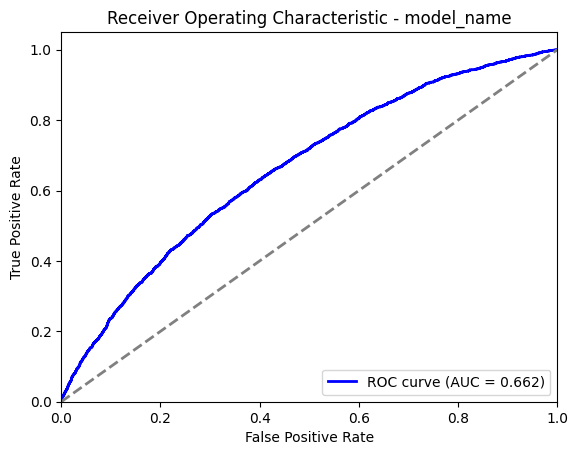

In [53]:
evaluate_model(y_pred,y_test,plot_roc=True)

In [4]:
df=df.set_index('customer')
df=df.drop(columns=['X','Unnamed: 0'])

In [5]:
df=df.drop(columns=['traintest','churndep'])

In [6]:
df.churn.value_counts()

churn
0    50438
1    20609
Name: count, dtype: int64

In [7]:
df[df.duplicated()]

,churn,revenue,mou,recchrge,directas,overage,roam,changem,changer,dropvce,blckvce,unansvce,custcare,threeway,mourec,outcalls,incalls,peakvce,opeakvce,dropblk,callfwdv,callwait,months,uniqsubs,actvsubs,phones,models,eqpdays,age1,age2,children,credita,creditaa,prizmrur,prizmub,prizmtwn,refurb,webcap,truck,rv,occprof,occcler,occcrft,occstud,occhmkr,occret,occself,ownrent,marryun,marryyes,mailord,mailres,mailflag,travel,pcown,creditcd,retcalls,retaccpt,newcelly,newcelln,refer,incmiss,income,mcycle,setprcm,setprc,retcall
customer,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


# EDA

In [8]:
# Split the data into training and testing sets
df, holdout_df = train_test_split(df, test_size=0.2, random_state=1973)

In [9]:
print(f'for test and training we have {len(df)} records and for holdout we have {len(holdout_df)} records, both data sets have {len(df.columns)} variables')

for test and training we have 56837 records and for holdout we have 14210 records, both data sets have 67 variables


In [10]:
df.head()

,churn,revenue,mou,recchrge,directas,overage,roam,changem,changer,dropvce,blckvce,unansvce,custcare,threeway,mourec,outcalls,incalls,peakvce,opeakvce,dropblk,callfwdv,callwait,months,uniqsubs,actvsubs,phones,models,eqpdays,age1,age2,children,credita,creditaa,prizmrur,prizmub,prizmtwn,refurb,webcap,truck,rv,occprof,occcler,occcrft,occstud,occhmkr,occret,occself,ownrent,marryun,marryyes,mailord,mailres,mailflag,travel,pcown,creditcd,retcalls,retaccpt,newcelly,newcelln,refer,incmiss,income,mcycle,setprcm,setprc,retcall
customer,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1086289,0,36.070000,244.00,49.990002,0.7425,18.75,0.000,-64.00,3.920000,0.333333,2.333333,33.333332,1.333333,0.0,36.786667,6.333333,1.666667,156.333328,10.666667,2.666667,0.0,0.000000,8,1,1,1.0,1.0,249.0,0.0,0.0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0.00000,0
1005115,1,11.545000,462.50,10.000000,0.4950,0.00,0.000,-113.50,2.655000,6.333333,0.000000,18.000000,0.000000,0.0,50.946667,4.000000,4.000000,248.000000,4.000000,6.333333,0.0,0.666667,39,2,2,2.0,2.0,643.0,0.0,0.0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,29.98999,0
1007178,1,31.325001,183.25,30.032499,0.4950,9.75,0.000,219.75,8.635000,1.000000,1.666667,9.333333,0.666667,0.0,39.860001,4.333333,0.000000,48.333332,21.000000,2.666667,0.0,0.000000,33,1,1,2.0,2.0,369.0,30.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,5,0,0,29.98999,0
1036599,0,61.189999,679.50,44.990002,0.0000,65.50,0.000,169.50,37.000000,2.333333,0.000000,27.333334,2.000000,0.0,193.206665,17.000000,5.333333,113.333336,125.000000,2.333333,0.0,2.000000,21,1,1,2.0,1.0,274.0,0.0,0.0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,29.98999,0
1037750,0,128.524994,1303.25,75.192497,3.7125,164.75,0.195,250.75,-49.575001,16.666666,0.000000,16.000000,0.333333,0.0,238.113327,43.333332,1.666667,153.666672,108.666664,16.666666,0.0,0.666667,21,1,1,3.0,3.0,65.0,0.0,0.0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,129.98999,0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56837 entries, 1086289 to 1095848
Data columns (total 67 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   churn     56837 non-null  int64  
 1   revenue   56659 non-null  float64
 2   mou       56659 non-null  float64
 3   recchrge  56659 non-null  float64
 4   directas  56659 non-null  float64
 5   overage   56659 non-null  float64
 6   roam      56659 non-null  float64
 7   changem   56427 non-null  float64
 8   changer   56427 non-null  float64
 9   dropvce   56837 non-null  float64
 10  blckvce   56837 non-null  float64
 11  unansvce  56837 non-null  float64
 12  custcare  56837 non-null  float64
 13  threeway  56837 non-null  float64
 14  mourec    56837 non-null  float64
 15  outcalls  56837 non-null  float64
 16  incalls   56837 non-null  float64
 17  peakvce   56837 non-null  float64
 18  opeakvce  56837 non-null  float64
 19  dropblk   56837 non-null  float64
 20  callfwdv  56837 non-null 

In [12]:
df.describe()

,churn,revenue,mou,recchrge,directas,overage,roam,changem,changer,dropvce,blckvce,unansvce,custcare,threeway,mourec,outcalls,incalls,peakvce,opeakvce,dropblk,callfwdv,callwait,months,uniqsubs,actvsubs,phones,models,eqpdays,age1,age2,children,credita,creditaa,prizmrur,prizmub,prizmtwn,refurb,webcap,truck,rv,occprof,occcler,occcrft,occstud,occhmkr,occret,occself,ownrent,marryun,marryyes,mailord,mailres,mailflag,travel,pcown,creditcd,retcalls,retaccpt,newcelly,newcelln,refer,incmiss,income,mcycle,setprcm,setprc,retcall
count,56837.000000,56659.000000,56659.000000,56659.000000,56659.000000,56659.000000,56659.000000,56427.000000,56427.000000,56837.000000,56837.000000,56837.000000,56837.000000,56837.000000,56837.000000,56837.000000,56837.000000,56837.000000,56837.000000,56837.000000,56837.000000,56837.000000,56837.000000,56837.000000,56837.000000,56836.000000,56836.000000,56836.000000,55827.000000,55827.000000,56837.000000,56837.000000,56837.000000,56837.000000,56837.000000,56837.000000,56837.000000,56837.000000,56837.000000,56837.000000,56837.000000,56837.000000,56837.000000,56837.000000,56837.000000,56837.000000,56837.000000,56837.000000,56837.000000,56837.000000,56837.000000,56837.000000,56837.000000,56837.000000,56837.000000,56837.000000,56837.000000,56837.000000,56837.000000,56837.000000,56837.000000,56837.000000,56837.000000,56837.000000,56837.000000,56837.000000,56837.000000
mean,0.290480,59.034589,527.497450,46.982687,0.897782,40.214610,1.229655,-10.881599,-1.208964,6.029502,4.074042,28.346778,1.868551,0.298168,115.383134,25.477852,8.228437,90.785460,67.875571,10.169218,0.013295,1.856886,18.740961,1.530271,1.352798,1.812689,1.565082,379.226476,31.321027,21.068354,0.242307,0.104316,0.129388,0.047821,0.319932,0.148460,0.139293,0.903426,0.187624,0.081180,0.174235,0.019670,0.029470,0.007601,0.003237,0.014093,0.017665,0.334096,0.385488,0.363830,0.360557,0.375741,0.014322,0.057445,0.185548,0.674719,0.036860,0.017735,0.192973,0.138642,0.050935,0.250330,4.325351,0.013407,0.565811,35.784137,0.033763
std,0.453988,44.319887,531.829995,23.999033,2.153971,96.816582,8.631494,256.921654,39.199892,9.047106,10.650452,38.774888,5.270965,1.140757,166.753748,35.285472,16.706397,105.177759,93.160185,15.345190,0.619152,5.484901,9.802193,0.869353,0.631248,1.346804,0.914101,253.801692,22.070344,23.871769,0.428483,0.305673,0.335631,0.213389,0.466454,0.355558,0.346255,0.295380,0.390415,0.273113,0.379315,0.138866,0.169122,0.086851,0.056806,0.117875,0.131730,0.471678,0.486715,0.481105,0.480166,0.484318,0.118814,0.232693,0.388745,0.468484,0.206507,0.141135,0.394635,0.345576,0.301121,0.433207,3.135490,0.115010,0.495654,56.924538,0.180621
min,0.000000,-6.167500,0.000000,-11.290000,0.000000,0.000000,0.000000,-3331.250000,-851.104981,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,1.000000,0.000000,1.000000,1.000000,-5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,33.673750,158.250000,30.000000,0.000000,0.000000,0.000000,-83.375000,-7.167500,0.666667,0.000000,5.333333,0.000000,0.000000,8.480000,3.333333,0.000000,23.000000,11.000000,1.666667,0.000000,0.000000,11.000000,1.000000,1.000000,1.000000,1.000000,204.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,48.757500,367.000000,44.990002,0.247500,2.500000,0.000000,-5.000000,-0.292500,3.000000,1.000

In [13]:
df.shape

(56837, 67)

## DEP VARIABLE

In [14]:
holdout_df['churn'].value_counts()

churn
0    10111
1     4099
Name: count, dtype: int64

In [15]:
holdout_df.describe()

,churn,revenue,mou,recchrge,directas,overage,roam,changem,changer,dropvce,blckvce,unansvce,custcare,threeway,mourec,outcalls,incalls,peakvce,opeakvce,dropblk,callfwdv,callwait,months,uniqsubs,actvsubs,phones,models,eqpdays,age1,age2,children,credita,creditaa,prizmrur,prizmub,prizmtwn,refurb,webcap,truck,rv,occprof,occcler,occcrft,occstud,occhmkr,occret,occself,ownrent,marryun,marryyes,mailord,mailres,mailflag,travel,pcown,creditcd,retcalls,retaccpt,newcelly,newcelln,refer,incmiss,income,mcycle,setprcm,setprc,retcall
count,14210.000000,14172.000000,14172.000000,14172.000000,14172.000000,14172.000000,14172.000000,14118.000000,14118.000000,14210.000000,14210.000000,14210.000000,14210.000000,14210.000000,14210.000000,14210.000000,14210.000000,14210.000000,14210.000000,14210.000000,14210.000000,14210.000000,14210.000000,14210.000000,14210.000000,14210.000000,14210.000000,14210.000000,13976.000000,13976.000000,14210.000000,14210.000000,14210.000000,14210.000000,14210.000000,14210.000000,14210.000000,14210.000000,14210.000000,14210.000000,14210.000000,14210.000000,14210.000000,14210.000000,14210.000000,14210.000000,14210.000000,14210.000000,14210.000000,14210.000000,14210.000000,14210.000000,14210.000000,14210.000000,14210.000000,14210.000000,14210.000000,14210.000000,14210.000000,14210.000000,14210.000000,14210.000000,14210.000000,14210.000000,14210.000000,14210.000000,14210.000000
mean,0.288459,58.126031,518.655783,46.450991,0.879016,39.618608,1.186755,-10.706020,-1.192324,5.931832,4.042998,28.392400,1.855384,0.308163,113.144186,25.071241,7.970256,89.762937,67.589819,10.071851,0.006005,1.837626,18.790289,1.526671,1.347080,1.792329,1.548628,384.421956,31.591156,21.514668,0.242716,0.104926,0.124842,0.047431,0.325827,0.148276,0.140887,0.900352,0.185574,0.081281,0.172555,0.021605,0.030331,0.007460,0.002815,0.016186,0.018508,0.323223,0.382125,0.371569,0.367628,0.383040,0.014778,0.057635,0.184870,0.683251,0.037579,0.018649,0.192822,0.139338,0.050528,0.247854,4.369740,0.013652,0.569317,35.856351,0.035116
std,0.453062,43.931242,523.258717,23.572571,2.364523,94.448694,10.691577,248.795284,37.004833,8.840192,10.752073,39.418772,4.694334,1.241299,164.495179,34.589517,15.746352,103.856343,94.004096,15.914072,0.216452,5.832855,9.729095,1.838898,0.764482,1.292425,0.884525,256.223915,22.128944,24.097282,0.428740,0.306469,0.330551,0.212567,0.468699,0.355386,0.347917,0.299541,0.388776,0.273275,0.377875,0.145393,0.171502,0.086049,0.052983,0.126194,0.134784,0.467724,0.485924,0.483241,0.482176,0.486145,0.120669,0.233061,0.388206,0.465225,0.203068,0.142876,0.394528,0.346312,0.243100,0.431782,3.143207,0.116047,0.495189,57.506248,0.184080
min,0.000000,-5.862500,0.000000,-5.330000,0.000000,0.000000,0.000000,-3875.000000,-1107.739990,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,1.000000,0.000000,1.000000,1.000000,-5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,33.556874,158.250000,30.000000,0.000000,0.000000,0.000000,-81.750000,-6.871875,0.666667,0.000000,5.333333,0.000000,0.000000,8.219166,3.333333,0.000000,22.666666,10.666667,1.666667,0.000000,0.000000,11.000000,1.000000,1.000000,1.000000,1.000000,206.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,47.676250,361.750000,44.990002,0.247500,2.750000,0.000000,-5.250000,-0.300000,3.000000,1.00

<Axes: xlabel='churn', ylabel='Count'>

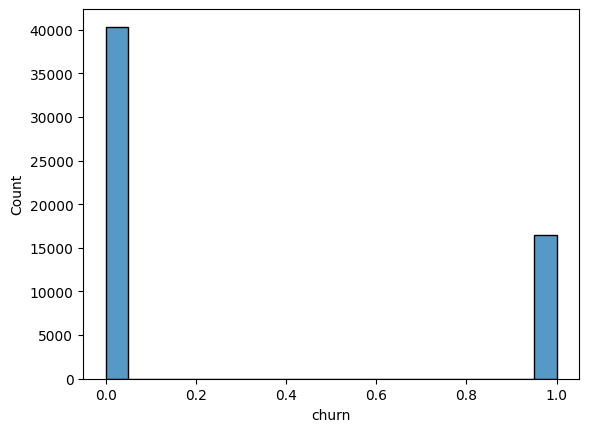

In [16]:
sns.histplot(df['churn'])

## FEATURES

In [17]:
def transform_binary_to_categorical(df_temp, binary_columns, new_col_name='def'):
    # Initialize the new categorical column with NaN
    df_temp[new_col_name] = np.nan
    
    for col in binary_columns:
        # Update the new column with the column name where the binary value is 1
        df_temp.loc[df[col] == 1, new_col_name] = col
        df_temp[new_col_name]=df_temp[new_col_name].fillna('other')
    # Optionally, you can drop the original binary columns
    df_temp.drop(columns=binary_columns, inplace=True)
    
    return df_temp

In [18]:
occ_cols=['occprof',
'occcler',
'occcrft',
'occstud',
'occhmkr',
'occret',
'occself']

In [19]:
prizm_cols=['prizmrur',
'prizmub',
'prizmtwn']

In [20]:
credit_cols=['credita',
'creditaa']

In [21]:
mail_cols=['mailord',
'mailres',
'mailflag']

In [22]:
martial_cols=['marryun',
'marryyes']

In [23]:
celusr_cols=['newcelly',
'newcelln']

In [24]:
df_exp=df.copy()

In [25]:
df_exp=transform_binary_to_categorical(df_exp,binary_columns=occ_cols,new_col_name='occupation')

In [26]:
df_exp=transform_binary_to_categorical(df_exp,binary_columns=prizm_cols,new_col_name='location')

In [27]:
df_exp=transform_binary_to_categorical(df_exp,binary_columns=credit_cols,new_col_name='credit')

In [28]:
df_exp=transform_binary_to_categorical(df_exp,binary_columns=mail_cols,new_col_name='mailstatus')

In [29]:
df_exp=transform_binary_to_categorical(df_exp,binary_columns=martial_cols,new_col_name='martial')

In [30]:
df_exp=transform_binary_to_categorical(df_exp,binary_columns=celusr_cols,new_col_name='cell_user_type')

In [31]:
df_exp.head()

,churn,revenue,mou,recchrge,directas,overage,roam,changem,changer,dropvce,blckvce,unansvce,custcare,threeway,mourec,outcalls,incalls,peakvce,opeakvce,dropblk,callfwdv,callwait,months,uniqsubs,actvsubs,phones,models,eqpdays,age1,age2,children,refurb,webcap,truck,rv,ownrent,travel,pcown,creditcd,retcalls,retaccpt,refer,incmiss,income,mcycle,setprcm,setprc,retcall,occupation,location,credit,mailstatus,martial,cell_user_type
customer,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1086289,0,36.070000,244.00,49.990002,0.7425,18.75,0.000,-64.00,3.920000,0.333333,2.333333,33.333332,1.333333,0.0,36.786667,6.333333,1.666667,156.333328,10.666667,2.666667,0.0,0.000000,8,1,1,1.0,1.0,249.0,0.0,0.0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0.00000,0,other,other,creditaa,other,marryun,other
1005115,1,11.545000,462.50,10.000000,0.4950,0.00,0.000,-113.50,2.655000,6.333333,0.000000,18.000000,0.000000,0.0,50.946667,4.000000,4.000000,248.000000,4.000000,6.333333,0.0,0.666667,39,2,2,2.0,2.0,643.0,0.0,0.0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,29.98999,0,other,prizmub,other,other,marryun,newcelln
1007178,1,31.325001,183.25,30.032499,0.4950,9.75,0.000,219.75,8.635000,1.000000,1.666667,9.333333,0.666667,0.0,39.860001,4.333333,0.000000,48.333332,21.000000,2.666667,0.0,0.000000,33,1,1,2.0,2.0,369.0,30.0,0.0,0,0,1,0,0,1,0,0,0,0,0,0,0,5,0,0,29.98999,0,other,other,other,other,other,newcelln
1036599,0,61.189999,679.50,44.990002,0.0000,65.50,0.000,169.50,37.000000,2.333333,0.000000,27.333334,2.000000,0.0,193.206665,17.000000,5.333333,113.333336,125.000000,2.333333,0.0,2.000000,21,1,1,2.0,1.0,274.0,0.0,0.0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,29.98999,0,other,prizmub,creditaa,other,marryun,newcelln
1037750,0,128.524994,1303.25,75.192497,3.7125,164.75,0.195,250.75,-49.575001,16.666666,0.000000,16.000000,0.333333,0.0,238.113327,43.333332,1.666667,153.666672,108.666664,16.666666,0.0,0.666667,21,1,1,3.0,3.0,65.0,0.0,0.0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,129.98999,0,other,prizmub,other,other,marryun,other


In [32]:
df_exp.shape

(56837, 54)

### Column variables renaming

In [33]:
mapping = {
    'occprof': 'professional',
    'occcler': 'clerical',
    'occcrft': 'crafts',
    'occstud': 'student',
    'occhmkr': 'homemaker',
    'occret': 'retired',
    'occself': 'self-employed'
}

df_exp['occupation']=df_exp['occupation'].replace(mapping, inplace=False)

In [34]:
mapping_prizm = {
    'prizmrur': 'rural',
    'prizmub': 'suburban',
    'prizmtwn': 'town'
}

df_exp['location']=df_exp['location'].replace(mapping_prizm, inplace=False)

In [35]:
# Define the mapping dictionary for the marriage status values
mapping_marriage = {
    'marryun': 'unknown',
    'marryyes': 'married'
}

df_exp['martial']=df_exp['martial'].replace(mapping_marriage, inplace=False)


In [36]:
mapping_credit = {
    'credita': 'a - rating',
    'creditaa': 'aa - rating',
}

df_exp['credit']=df_exp['credit'].replace(mapping_credit, inplace=False)

In [37]:
mapping_mail = {
    'mailord': 'buys via mail',
    'mailres': 'responds to mail',
    'mailflag': 'doesnt want mail'
}

df_exp['mailstatus']=df_exp['mailstatus'].replace(mapping_mail, inplace=False)

In [38]:
mapping_phone = {
    'newcelly': 'new cell phone',
    'newcelln': 'no new cell phone'
}

df_exp['cell_user_type']=df_exp['cell_user_type'].replace(mapping_phone, inplace=False)

In [39]:
def plot_eda(columns,df_fun=df_exp, num_cols=2, plt_type='hist', churn_col='churn', col_labels=False):
    # Get the unique values of the churn column
    churn_values = df_fun[churn_col].unique()
    colors = ['blue', 'orange']  # Colors for different churn categories

    # Set up the figure and axes for multiple plots
    num_plots = len(columns)
    num_rows = (num_plots + num_cols - 1) // num_cols  # Calculate the number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 4 * num_rows))
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    for i, col in enumerate(columns):
        ax = axes[i]
        
        # Create a list to store the histogram data
        hist_data = []
        
        for churn_val in churn_values:
            hist_data.append(df_fun[df_fun[churn_col] == churn_val][col])
        
        # Plot the stacked histogram
        ax.hist(hist_data, bins=30, edgecolor='black', stacked=False, color=colors, label=[f'Churn: {churn_val}' for churn_val in churn_values])
        
        ax.set_title(f'Distribution of {col}')
        ax.set_ylabel('Frequency')
        ax.grid(True)
        ax.legend()  # Add legend to differentiate churn categories

        if col_labels is True:
            ax.set_xlabel(col)
        else: 
            ax.set_xlabel('')
        
    # Remove any empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


In [40]:
def plot_eda_density(columns, df_fun=df_exp, num_cols=2, churn_col='churn', col_labels=False):
    # Get the unique values of the churn column
    churn_values = df_fun[churn_col].unique()
    colors = ['blue', 'orange']  # Colors for different churn categories

    # Set up the figure and axes for multiple plots
    num_plots = len(columns)
    num_rows = (num_plots + num_cols - 1) // num_cols  # Calculate the number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 4 * num_rows))
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    for i, col in enumerate(columns):
        ax = axes[i]

        for j, churn_val in enumerate(churn_values):
            # Plot the density plot
            sns.kdeplot(df_fun[df_fun[churn_col] == churn_val][col], 
                        ax=ax, 
                        color=colors[j], 
                        label=f'Churn: {churn_val}',
                        fill=True)  # fill=True adds shading under the curve

        ax.set_title(f'Wykres gęstości {col}')
        ax.set_ylabel('udział')
        ax.grid(True)
        ax.legend()  # Add legend to differentiate churn categories

        if col_labels:
            ax.set_xlabel(col)
        else:
            ax.set_xlabel('')
        
    # Remove any empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [41]:
numerical_cols = [col for col in df_exp.select_dtypes(include=['number']).columns if df_exp[col].nunique() >= 3]

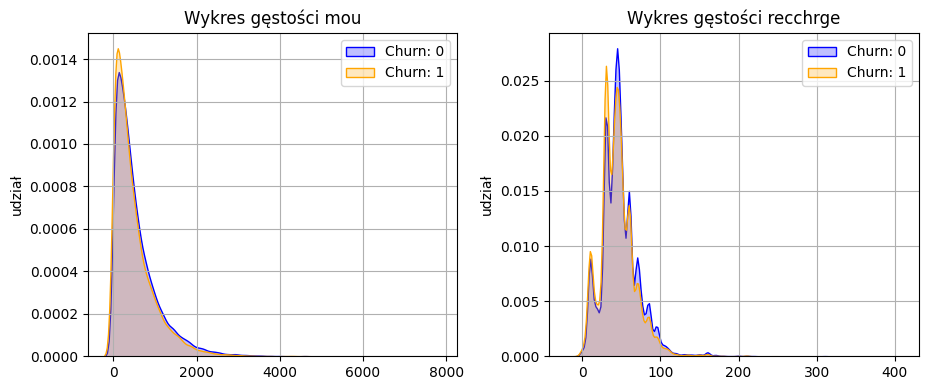

In [42]:
plot_eda_density(numerical_cols[1:3],num_cols=3)

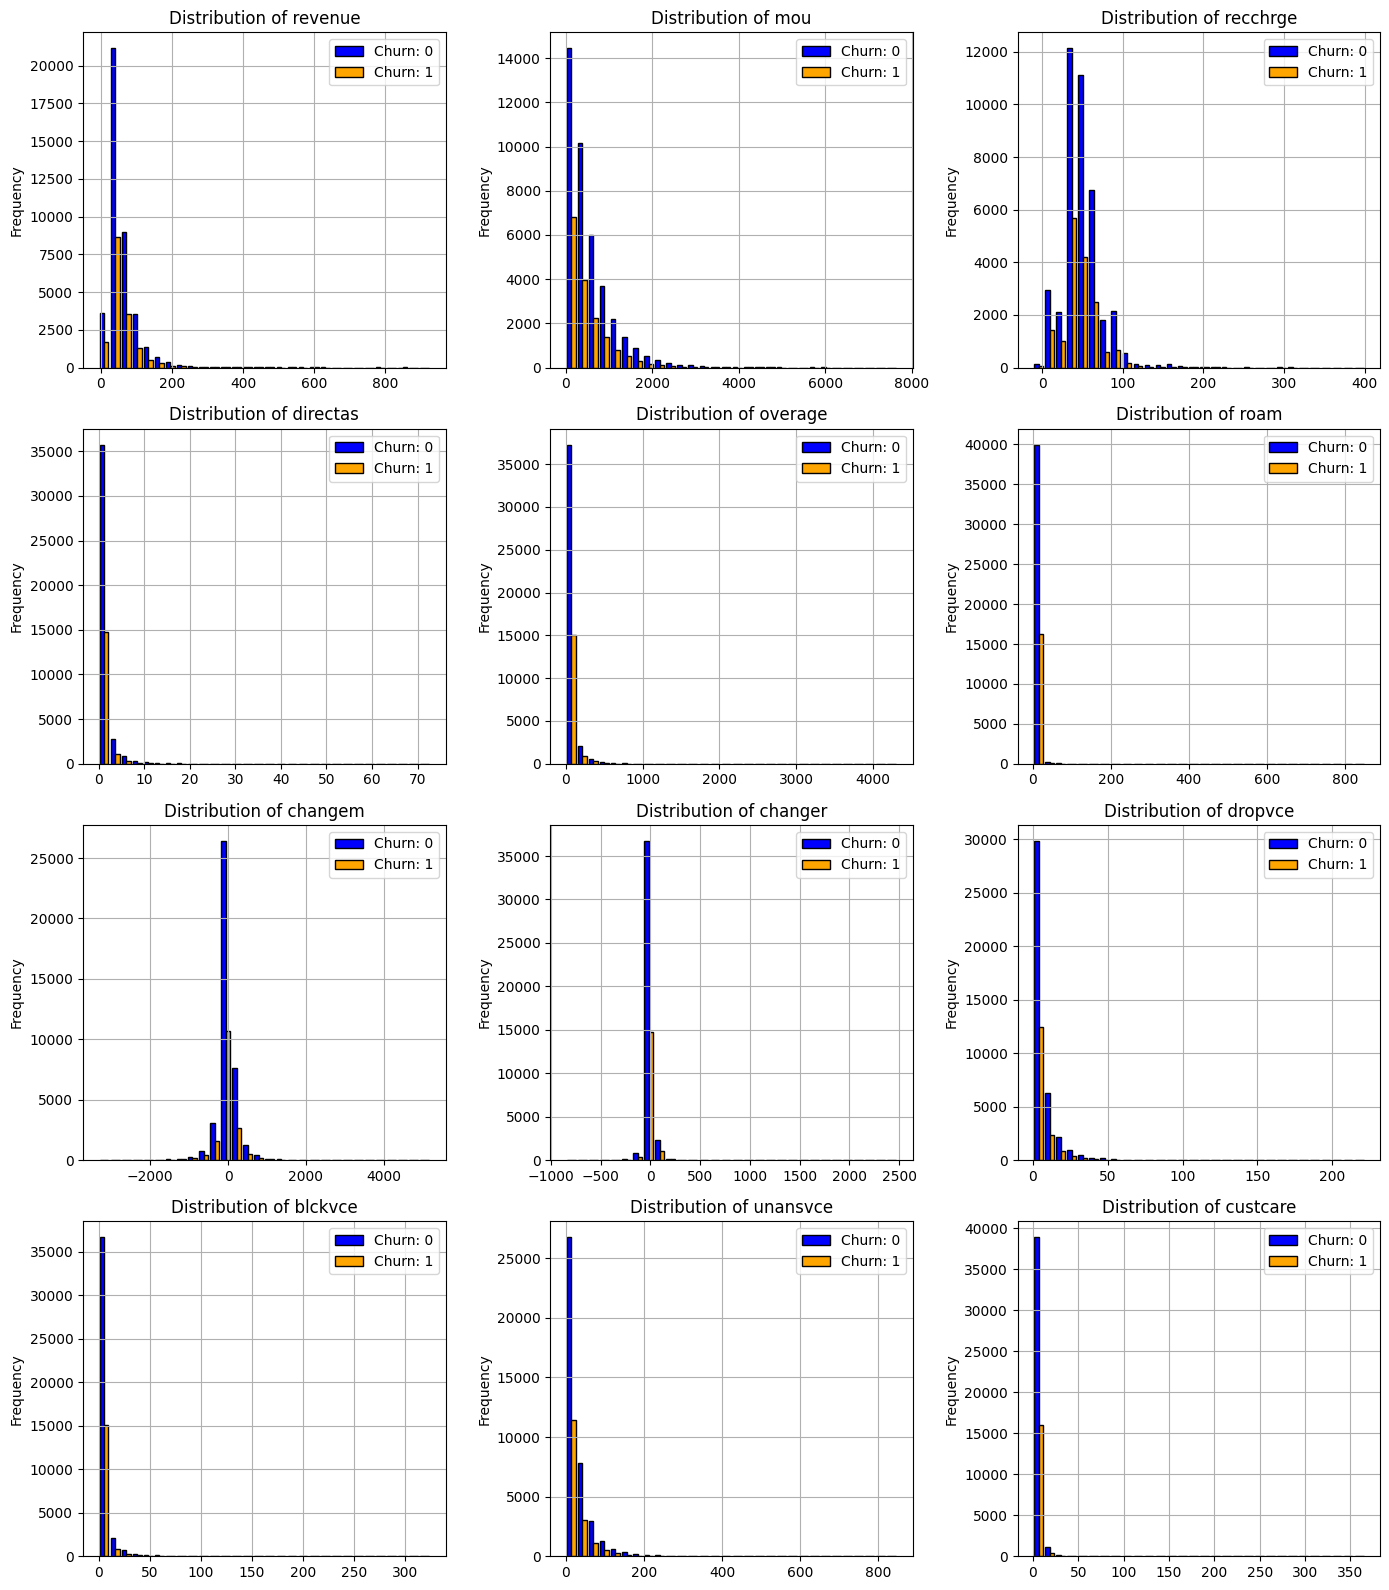

In [43]:
plot_eda(numerical_cols[0:12],num_cols=3)

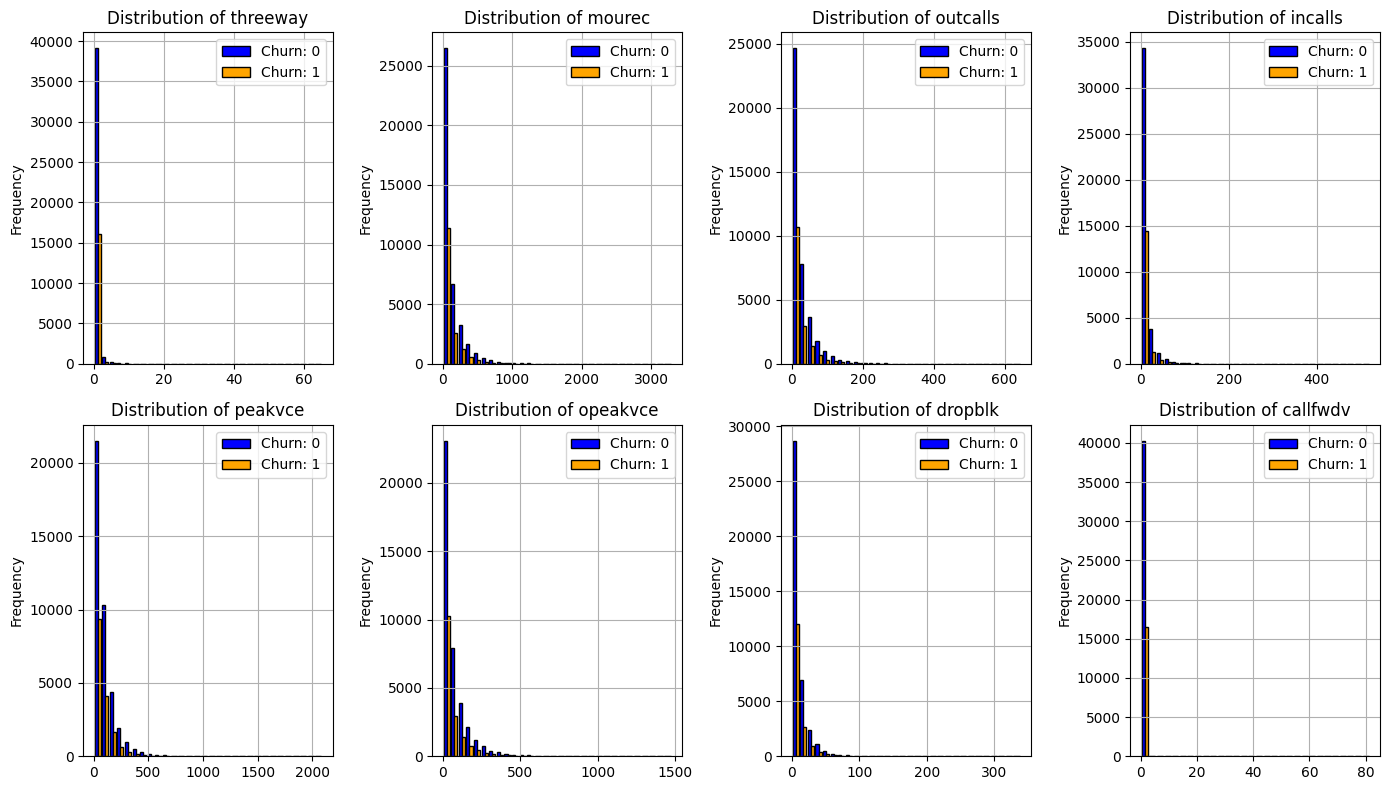

In [44]:
plot_eda(numerical_cols[12:20],num_cols=4)

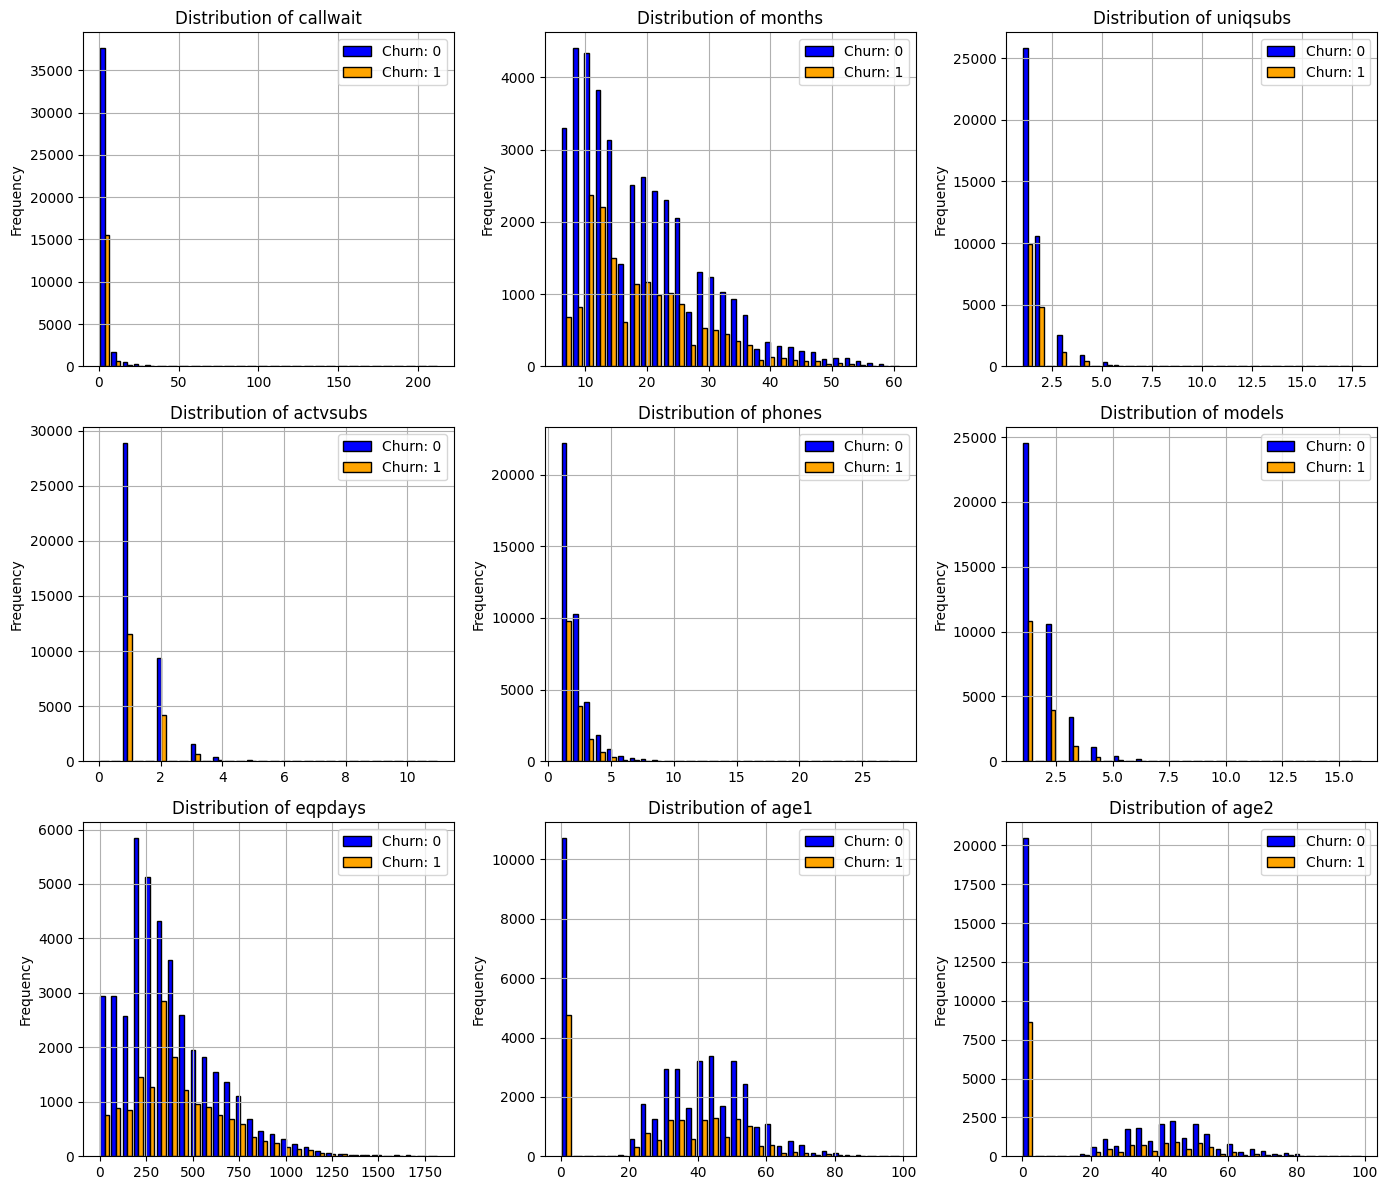

In [45]:
plot_eda(numerical_cols[20:29],num_cols=3)

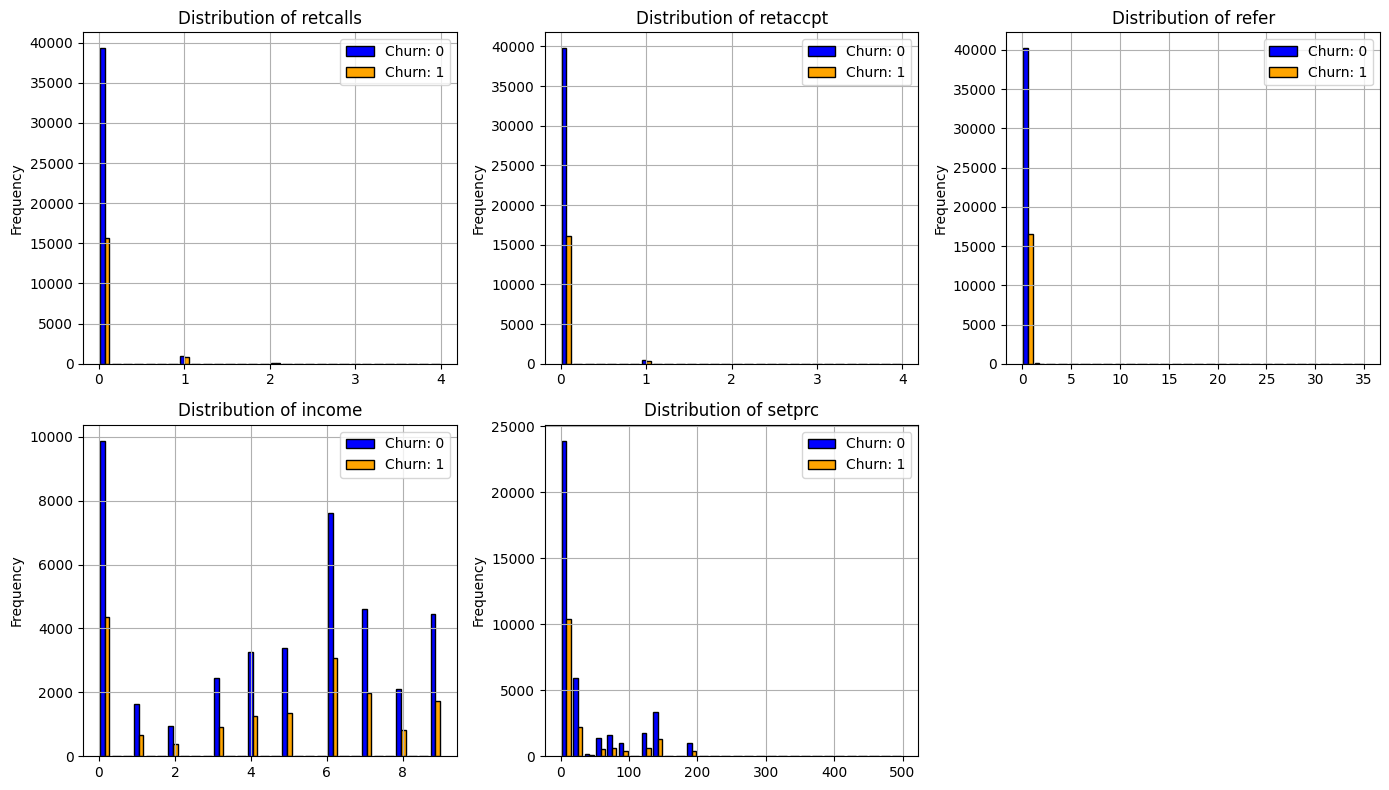

In [46]:
plot_eda(numerical_cols[29:],num_cols=3)

In [47]:
df_exp[df_exp.age1!=0]

,churn,revenue,mou,recchrge,directas,overage,roam,changem,changer,dropvce,blckvce,unansvce,custcare,threeway,mourec,outcalls,incalls,peakvce,opeakvce,dropblk,callfwdv,callwait,months,uniqsubs,actvsubs,phones,models,eqpdays,age1,age2,children,refurb,webcap,truck,rv,ownrent,travel,pcown,creditcd,retcalls,retaccpt,refer,incmiss,income,mcycle,setprcm,setprc,retcall,occupation,location,credit,mailstatus,martial,cell_user_type
customer,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1007178,1,31.325001,183.25,30.032499,0.4950,9.75,0.0000,219.75,8.6350,1.000000,1.666667,9.333333,0.666667,0.000000,39.860001,4.333333,0.000000,48.333332,21.000000,2.666667,0.0,0.000000,33,1,1,2.0,2.0,369.0,30.0,0.0,0,0,1,0,0,1,0,0,0,0,0,0,0,5,0,0,29.98999,0,other,other,other,other,other,no new cell phone
1007776,0,50.567501,25.75,50.000000,0.2475,0.00,0.3200,22.25,1.7025,0.000000,0.666667,4.666667,0.000000,0.000000,1.413333,2.666667,0.000000,2.333333,10.000000,0.666667,0.0,0.000000,35,1,1,1.0,1.0,1036.0,44.0,28.0,0,0,0,0,0,0,0,0,1,0,0,0,0,9,0,1,0.00000,0,professional,suburban,other,other,unknown,other
1010114,0,32.985001,182.75,32.490002,0.4950,0.00,0.0000,21.25,-0.4950,2.333333,0.000000,17.000000,0.000000,0.000000,26.480000,16.666666,5.000000,63.333332,15.333333,2.333333,0.0,0.000000,33,2,2,2.0,2.0,587.0,28.0,0.0,0,1,1,0,0,0,0,0,1,0,0,0,0,9,0,0,29.98999,0,other,other,other,responds to mail,other,new cell phone
1021138,1,97.684998,849.50,74.989998,1.2375,75.50,2.5825,-480.50,-20.1250,12.000000,1.000000,44.666668,0.000000,0.000000,276.073334,35.000000,1.333333,154.666672,98.666664,13.000000,0.0,0.000000,26,3,3,1.0,1.0,773.0,NaN,NaN,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0.00000,0,other,other,other,other,unknown,other
1095450,0,69.930000,832.75,69.989998,5.9400,0.00,0.0000,150.25,8.9100,2.333333,5.000000,20.666666,0.000000,0.000000,263.143341,52.666668,39.000000,115.666664,111.000000,7.333333,0.0,3.000000,9,1,1,2.0,2.0,66.0,28.0,0.0,0,1,1,0,0,0,0,0,1,0,0,0,0,3,0,0,149.98999,0,other,other,a - rating,other,married,new cell phone
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1059088,0,46.134998,263.50,44.990002,0.4950,23.50,0.0000,-41.50,-9.1650,7.000000,6.000000,14.333333,0.000000,0.000000,71.443336,4.333333,0.333333,34.333332,9.666667,13.000000,0.0,0.000000,15,1,1,1.0,1.0,433.0,44.0,34.0,1,0,1,0,0,0,0,0,1,0,0,0,0,4,0,1,0.00000,0,other,other,a - rating,other,married,other
1039823,0,14.525000,145.25,10.000000,0.0000,1.50,0.0000,51.75,-0.5250,2.000000,1.000000,6.666667,0.000000,0.333333,20.933332,8.333333,4.333333,19.333334,8.000000,3.000000,0.0,0.333333,20,2,2,1.0,1.0,596.0,50.0,0.0,0,1,1,0,0,0,0,0,1,0,0,0,0,8,0,1,0.00000,0,other,suburban,other,responds to mail,married,new cell phone
1078415,0,43.785000,82.00,48.537498,0.2475,0.00,0.0000,-59.00,-3.6350,1.333333,0.000000,8.333333,2.333333,0.000000,23.323334,5.333333,0.000000,21.000000,23.333334,1.333333,0.0,0.000000,9,1,1,3.0,2.0,173.0,48.0,46.0,0,0,1,0,0,0,0,1,1,0,0,0,0,2,0,0,129.98999,0,crafts,other,a - rating,responds to mail,other,other


In [48]:
df_exp['household_avg_age']=(df_exp[df_exp.age1!=0].age1+df_exp[df_exp.age2!=0].age2)/2

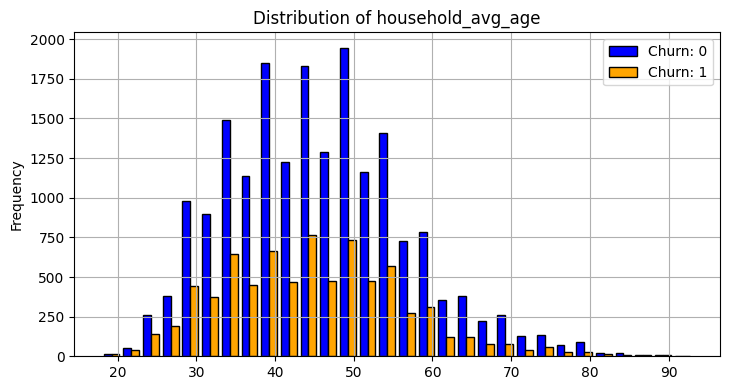

In [49]:
plot_eda(['household_avg_age'])

In [50]:
def plot_eda_binary(columns, df_fun=df_exp, num_cols=2, churn_col='churn',col_labels=True):
    # Get the unique values of the churn column
    churn_values = df_fun[churn_col].unique()
    colors = ['blue', 'orange']  # Colors for different churn categories

    # Set up the figure and axes for multiple plots
    num_plots = len(columns)
    num_rows = (num_plots + num_cols - 1) // num_cols  # Calculate the number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 4 * num_rows))
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    for i, col in enumerate(columns):
        ax = axes[i]

        # Calculate the frequencies for each churn category
        bar_positions = np.arange(len(df_fun[col].unique()))  # Positions for the bars
        bar_width = 0.35  # Width of each bar

        for j, churn_val in enumerate(churn_values):
            data_subset = df_fun[df_fun[churn_col] == churn_val][col].value_counts().sort_index()
            ax.bar(bar_positions + j * bar_width, data_subset, width=bar_width, color=colors[j], label=f'Churn: {churn_val}',edgecolor='black')

        ax.set_title(f'{col}')
        ax.set_ylabel('Frequency')
        ax.set_xticks(bar_positions + bar_width / 2)
        ax.set_xticklabels(data_subset.index, rotation=45)  # Rotate labels for readability
        ax.grid(True)
        ax.legend()  # Add legend to differentiate churn categories
        if col_labels is True:
            ax.set_xlabel(col)
        else: 
            ax.set_xlabel('')

    # Remove any empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [51]:
binary_cols = [col for col in df_exp.select_dtypes(include=['number']).columns if df_exp[col].nunique() == 2 and col != 'churn']

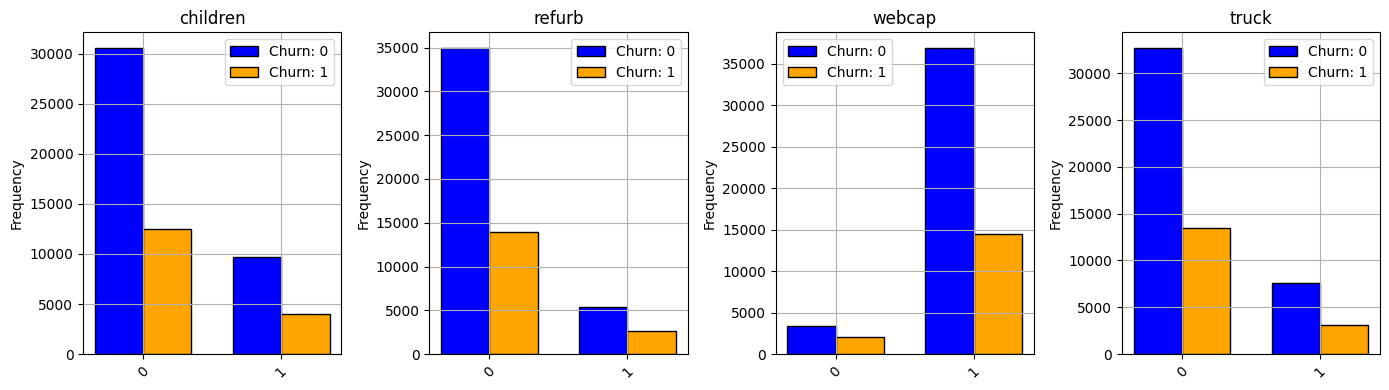

In [52]:
plot_eda_binary(binary_cols[0:4],num_cols=4,col_labels=False)

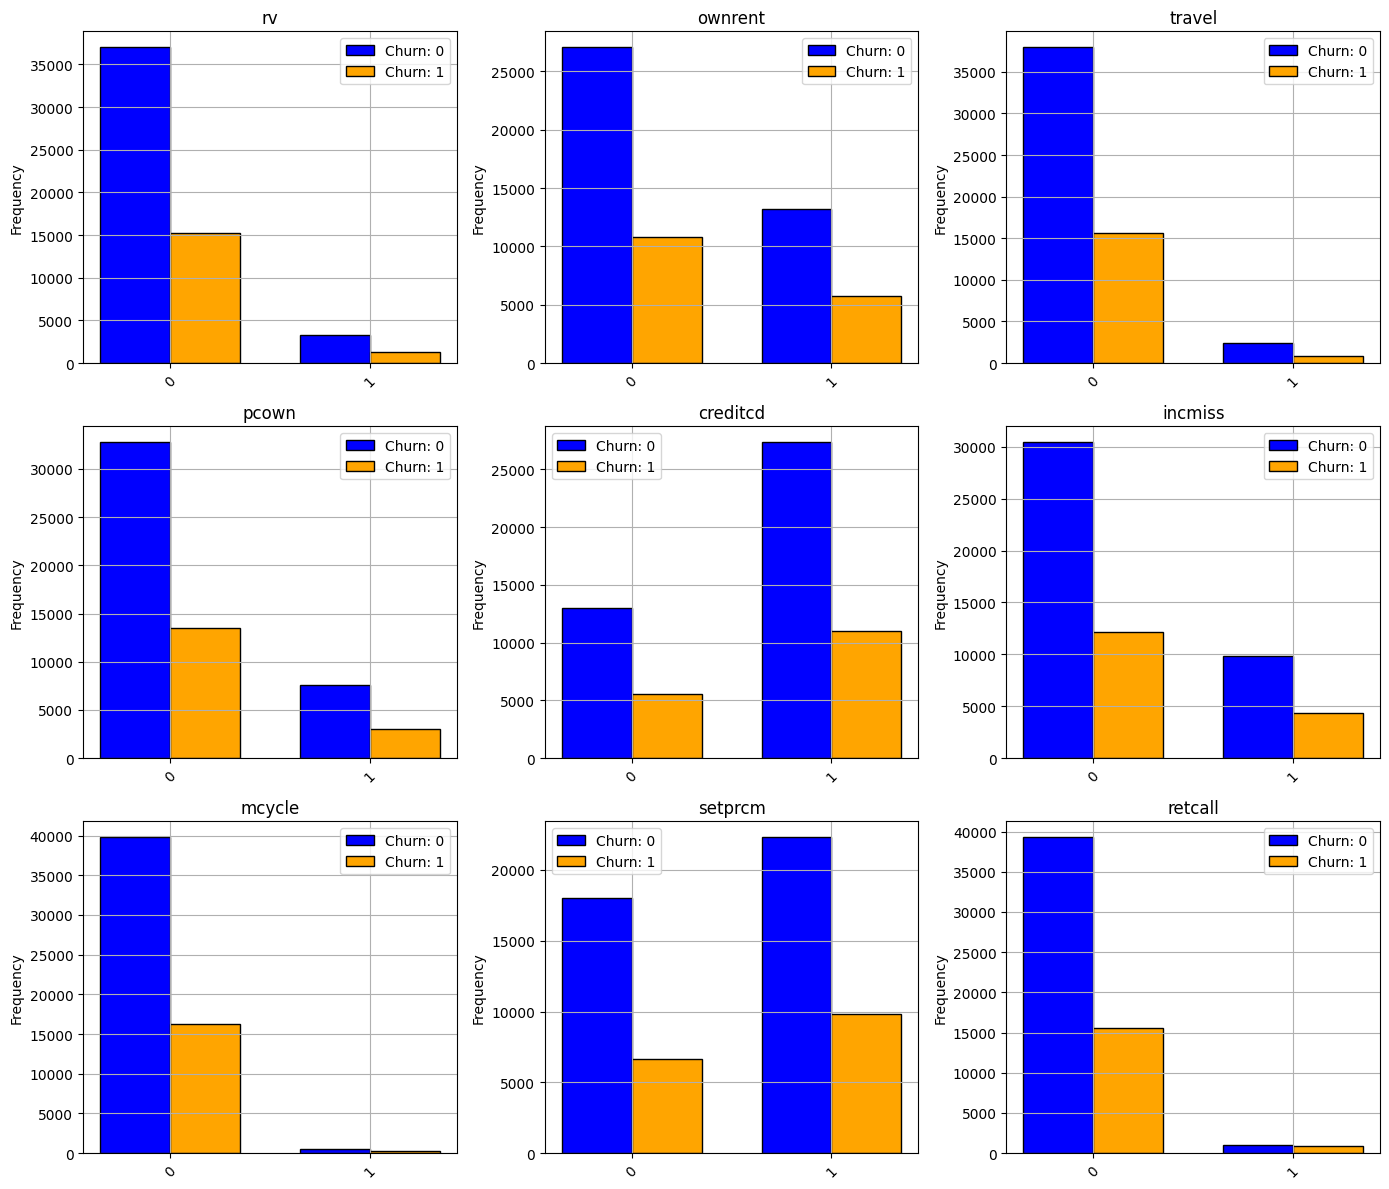

In [53]:
plot_eda_binary(binary_cols[4:],num_cols=3,col_labels=False)

In [54]:
df_exp['churn'][(df_exp.refurb==1)&(df_exp.webcap==0)].value_counts()

churn
0    605
1    421
Name: count, dtype: int64

In [55]:
df_exp['churn'][(df_exp.retcall==1)].value_counts()

churn
0    1018
1     901
Name: count, dtype: int64

In [56]:
1102/(1102+515)

0.6815089672232529

In [57]:
df_exp.shape

(56837, 55)

In [58]:
cat_cols = ['occupation','location','credit','mailstatus','martial','cell_user_type']

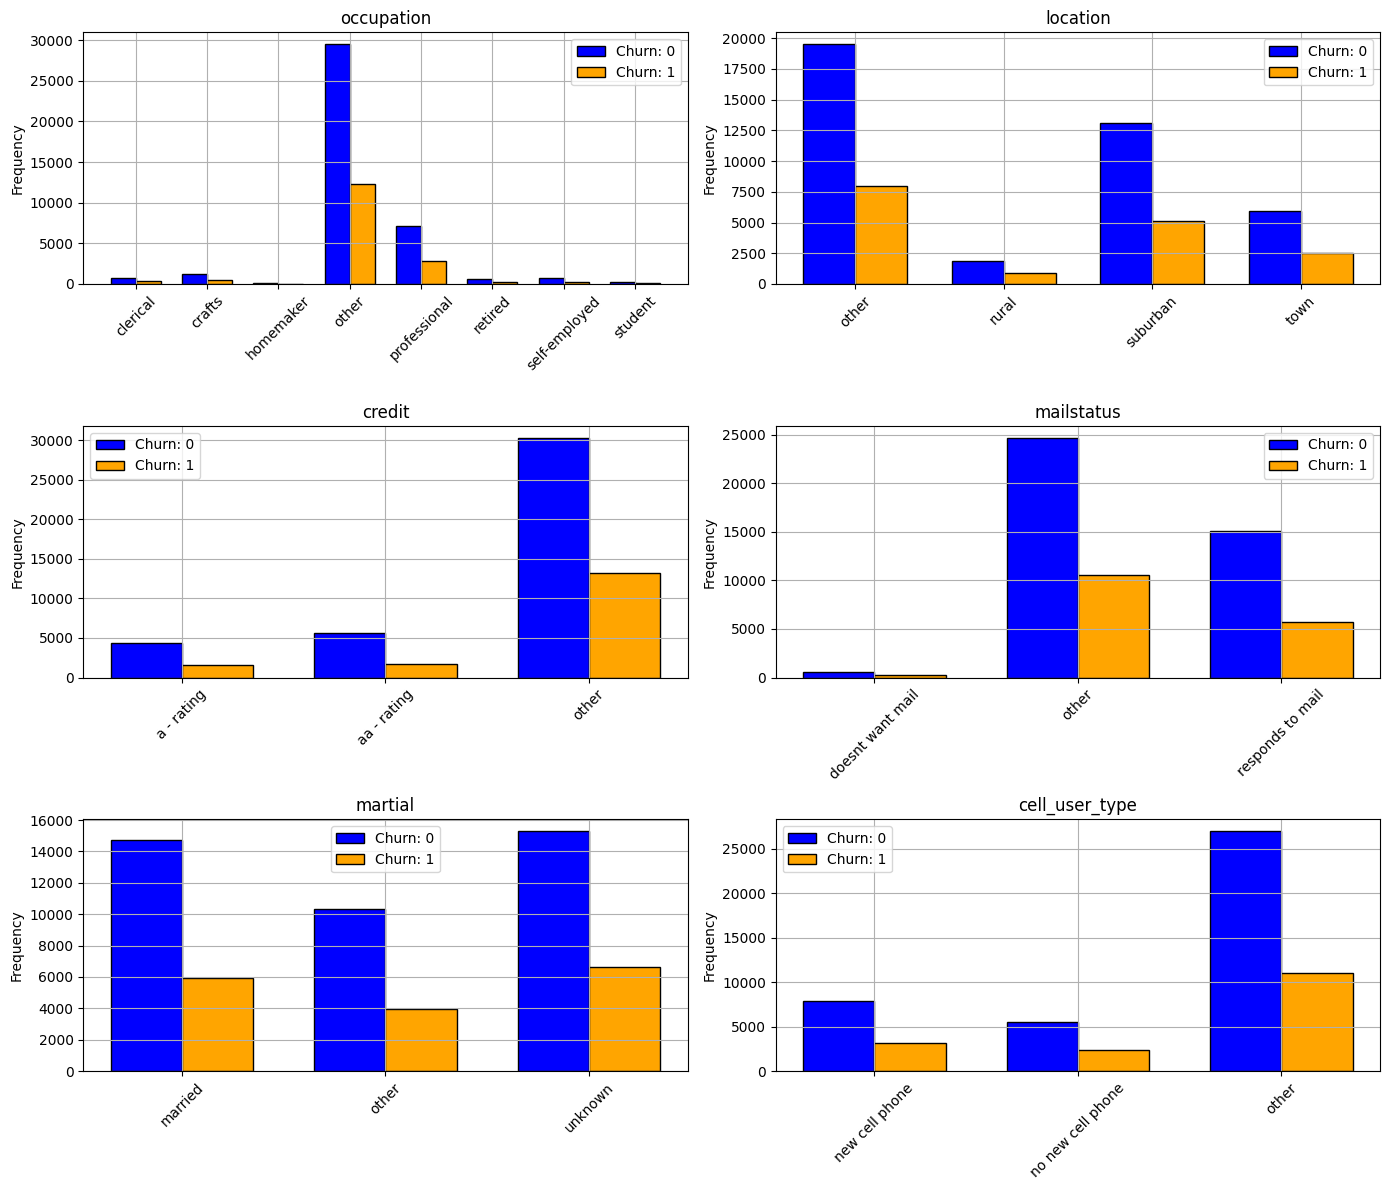

In [59]:
plot_eda_binary(cat_cols,num_cols=2,col_labels=False)

In [60]:
pd.DataFrame(df_exp[df_exp.columns[df_exp.isna().sum() > 0]].isna().sum()).T

,revenue,mou,recchrge,directas,overage,roam,changem,changer,phones,models,eqpdays,age1,age2,household_avg_age
0,178,178,178,178,178,178,410,410,1,1,1,1010,1010,30098


In [61]:
df_exp

,churn,revenue,mou,recchrge,directas,overage,roam,changem,changer,dropvce,blckvce,unansvce,custcare,threeway,mourec,outcalls,incalls,peakvce,opeakvce,dropblk,callfwdv,callwait,months,uniqsubs,actvsubs,phones,models,eqpdays,age1,age2,children,refurb,webcap,truck,rv,ownrent,travel,pcown,creditcd,retcalls,retaccpt,refer,incmiss,income,mcycle,setprcm,setprc,retcall,occupation,location,credit,mailstatus,martial,cell_user_type,household_avg_age
customer,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1086289,0,36.070000,244.00,49.990002,0.7425,18.75,0.000,-64.00,3.920000,0.333333,2.333333,33.333332,1.333333,0.000000,36.786667,6.333333,1.666667,156.333328,10.666667,2.666667,0.0,0.000000,8,1,1,1.0,1.0,249.0,0.0,0.0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0.00000,0,other,other,aa - rating,other,unknown,other,NaN
1005115,1,11.545000,462.50,10.000000,0.4950,0.00,0.000,-113.50,2.655000,6.333333,0.000000,18.000000,0.000000,0.000000,50.946667,4.000000,4.000000,248.000000,4.000000,6.333333,0.0,0.666667,39,2,2,2.0,2.0,643.0,0.0,0.0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,29.98999,0,other,suburban,other,other,unknown,no new cell phone,NaN
1007178,1,31.325001,183.25,30.032499,0.4950,9.75,0.000,219.75,8.635000,1.000000,1.666667,9.333333,0.666667,0.000000,39.860001,4.333333,0.000000,48.333332,21.000000,2.666667,0.0,0.000000,33,1,1,2.0,2.0,369.0,30.0,0.0,0,0,1,0,0,1,0,0,0,0,0,0,0,5,0,0,29.98999,0,other,other,other,other,other,no new cell phone,NaN
1036599,0,61.189999,679.50,44.990002,0.0000,65.50,0.000,169.50,37.000000,2.333333,0.000000,27.333334,2.000000,0.000000,193.206665,17.000000,5.333333,113.333336,125.000000,2.333333,0.0,2.000000,21,1,1,2.0,1.0,274.0,0.0,0.0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,29.98999,0,other,suburban,aa - rating,other,unknown,no new cell phone,NaN
1037750,0,128.524994,1303.25,75.192497,3.7125,164.75,0.195,250.75,-49.575001,16.666666,0.000000,16.000000,0.333333,0.000000,238.113327,43.333332,1.666667,153.666672,108.666664,16.666666,0.0,0.666667,21,1,1,3.0,3.0,65.0,0.0,0.0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,129.98999,0,other,suburban,other,other,unknown,other,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1059088,0,46.134998,263.50,44.990002,0.4950,23.50,0.000,-41.50,-9.165000,7.000000,6.000000,14.333333,0.000000,0.000000,71.443336,4.333333,0.333333,34.333332,9.666667,13.000000,0.0,0.000000,15,1,1,1.0,1.0,433.0,44.0,34.0,1,0,1,0,0,0,0,0,1,0,0,0,0,4,0,1,0.00000,0,other,other,a - rating,other,married,other,39.0
1039823,0,14.525000,145.25,10.000000,0.0000,1.50,0.000,51.75,-0.525000,2.000000,1.000000,6.666667,0.000000,0.333333,20.933332,8.333333,4.333333,19.333334,8.000000,3.000000,0.0,0.333333,20,2,2,1.0,1.0,596.0,50.0,0.0,0,1,1,0,0,0,0,0,1,0,0,0,0,8,0,1,0.00000,0,other,suburban,other,responds to mail,married,new cell phone,NaN
1078415,0,43.785000,82.00,48.537498,0.2475,0.00,0.000,-59.00,-3.635000,1.333333,0.000000,8.333333,2.333333,0.000000,23.323334,5.333333,0.000000,21.000000,23.333334,1.333333,0.0,0.000000,9,1,1,3.0,2.0,173.0,48.0,46.0,0,0,1,0,0,0,0,1,1,0,0,0,0,2,0,0,129.98999,0,crafts,other,a - rating,responds to mail,other,other,47.0


# Data Transformation

In [62]:
df

,churn,revenue,mou,recchrge,directas,overage,roam,changem,changer,dropvce,blckvce,unansvce,custcare,threeway,mourec,outcalls,incalls,peakvce,opeakvce,dropblk,callfwdv,callwait,months,uniqsubs,actvsubs,phones,models,eqpdays,age1,age2,children,credita,creditaa,prizmrur,prizmub,prizmtwn,refurb,webcap,truck,rv,occprof,occcler,occcrft,occstud,occhmkr,occret,occself,ownrent,marryun,marryyes,mailord,mailres,mailflag,travel,pcown,creditcd,retcalls,retaccpt,newcelly,newcelln,refer,incmiss,income,mcycle,setprcm,setprc,retcall
customer,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1086289,0,36.070000,244.00,49.990002,0.7425,18.75,0.000,-64.00,3.920000,0.333333,2.333333,33.333332,1.333333,0.000000,36.786667,6.333333,1.666667,156.333328,10.666667,2.666667,0.0,0.000000,8,1,1,1.0,1.0,249.0,0.0,0.0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0.00000,0
1005115,1,11.545000,462.50,10.000000,0.4950,0.00,0.000,-113.50,2.655000,6.333333,0.000000,18.000000,0.000000,0.000000,50.946667,4.000000,4.000000,248.000000,4.000000,6.333333,0.0,0.666667,39,2,2,2.0,2.0,643.0,0.0,0.0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,29.98999,0
1007178,1,31.325001,183.25,30.032499,0.4950,9.75,0.000,219.75,8.635000,1.000000,1.666667,9.333333,0.666667,0.000000,39.860001,4.333333,0.000000,48.333332,21.000000,2.666667,0.0,0.000000,33,1,1,2.0,2.0,369.0,30.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,5,0,0,29.98999,0
1036599,0,61.189999,679.50,44.990002,0.0000,65.50,0.000,169.50,37.000000,2.333333,0.000000,27.333334,2.000000,0.000000,193.206665,17.000000,5.333333,113.333336,125.000000,2.333333,0.0,2.000000,21,1,1,2.0,1.0,274.0,0.0,0.0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,29.98999,0
1037750,0,128.524994,1303.25,75.192497,3.7125,164.75,0.195,250.75,-49.575001,16.666666,0.000000,16.000000,0.333333,0.000000,238.113327,43.333332,1.666667,153.666672,108.666664,16.666666,0.0,0.666667,21,1,1,3.0,3.0,65.0,0.0,0.0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,129.98999,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1059088,0,46.134998,263.50,44.990002,0.4950,23.50,0.000,-41.50,-9.165000,7.000000,6.000000,14.333333,0.000000,0.000000,71.443336,4.333333,0.333333,34.333332,9.666667,13.000000,0.0,0.000000,15,1,1,1.0,1.0,433.0,44.0,34.0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,4,0,1,0.00000,0
1039823,0,14.525000,145.25,10.000000,0.0000,1.50,0.000,51.75,-0.525000,2.000000,1.000000,6.666667,0.000000,0.333333,20.933332,8.333333,4.333333,19.333334,8.000000,3.000000,0.0,0.333333,20,2,2,1.0,1.0,596.0,50.0,0.0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,1,0,0,0,8,0,1,0.00000,0
1078415,0,43.785000,82.00,48.537498,0.2475,0.00,0.000,-59.00,-3.635000,1.333333,0.000000,8.333333,2.333333,0.000000,23.323334,5.333333,0.000000,21.000000,23.333334,1.333333,0.0,0.000000,9,1,1,3.0,2.0,173.0,48.0,46.0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,2,0,0,129.98999,0


In [63]:
df[df.columns[df.isna().sum() > 0]].info()

<class 'pandas.core.frame.DataFrame'>
Index: 56837 entries, 1086289 to 1095848
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   revenue   56659 non-null  float64
 1   mou       56659 non-null  float64
 2   recchrge  56659 non-null  float64
 3   directas  56659 non-null  float64
 4   overage   56659 non-null  float64
 5   roam      56659 non-null  float64
 6   changem   56427 non-null  float64
 7   changer   56427 non-null  float64
 8   phones    56836 non-null  float64
 9   models    56836 non-null  float64
 10  eqpdays   56836 non-null  float64
 11  age1      55827 non-null  float64
 12  age2      55827 non-null  float64
dtypes: float64(13)
memory usage: 6.1 MB


In [64]:
df[df.columns[df.isna().sum() > 0]].isna().sum()

revenue      178
mou          178
recchrge     178
directas     178
overage      178
roam         178
changem      410
changer      410
phones         1
models         1
eqpdays        1
age1        1010
age2        1010
dtype: int64

In [65]:
df[df.phones.isna()]

,churn,revenue,mou,recchrge,directas,overage,roam,changem,changer,dropvce,blckvce,unansvce,custcare,threeway,mourec,outcalls,incalls,peakvce,opeakvce,dropblk,callfwdv,callwait,months,uniqsubs,actvsubs,phones,models,eqpdays,age1,age2,children,credita,creditaa,prizmrur,prizmub,prizmtwn,refurb,webcap,truck,rv,occprof,occcler,occcrft,occstud,occhmkr,occret,occself,ownrent,marryun,marryyes,mailord,mailres,mailflag,travel,pcown,creditcd,retcalls,retaccpt,newcelly,newcelln,refer,incmiss,income,mcycle,setprcm,setprc,retcall
customer,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1077200,0,76.980003,0.0,86.980003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13,1,1,NaN,NaN,NaN,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0.0,0


In [66]:
df = df.dropna(subset=['phones'])
df[df.columns[df.isna().sum() > 0]].isna().sum()

revenue      178
mou          178
recchrge     178
directas     178
overage      178
roam         178
changem      410
changer      410
age1        1010
age2        1010
dtype: int64

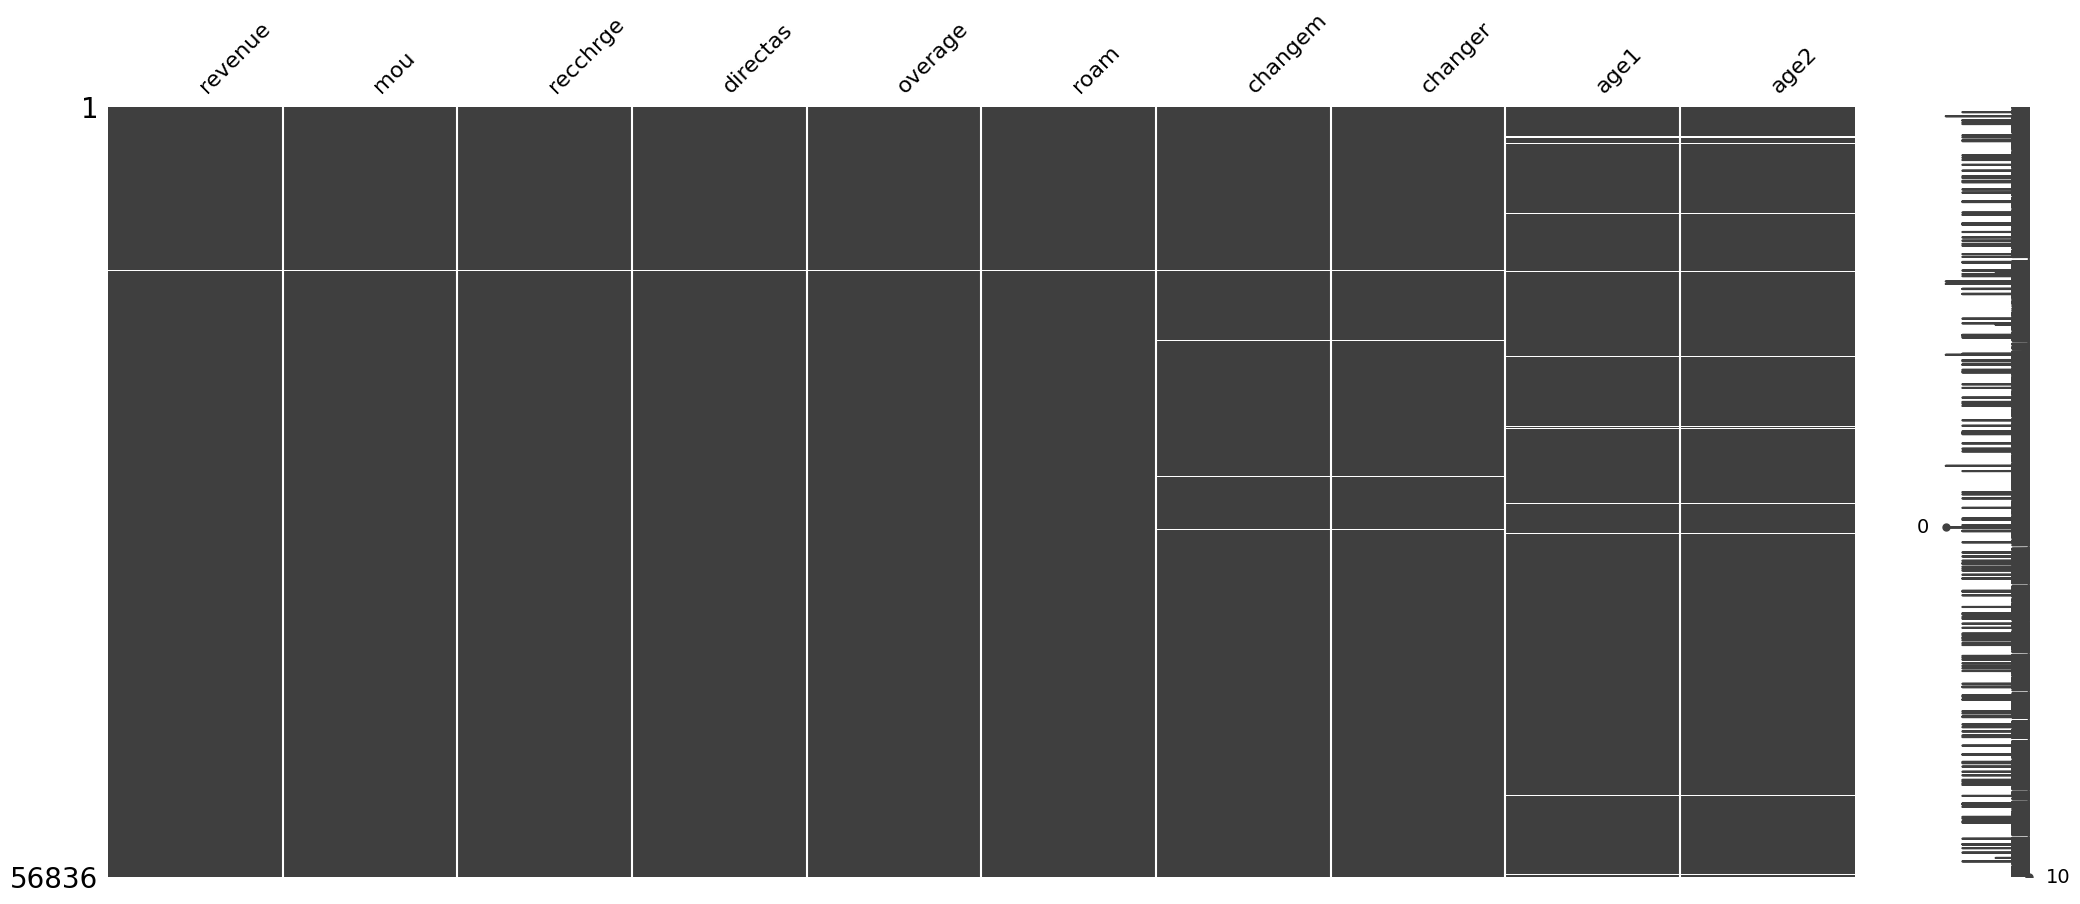

In [67]:
msno.matrix(df.loc[:, df.isna().any()])
plt.show()

Text(0.5, 1.0, 'Heatmapa braków danych')

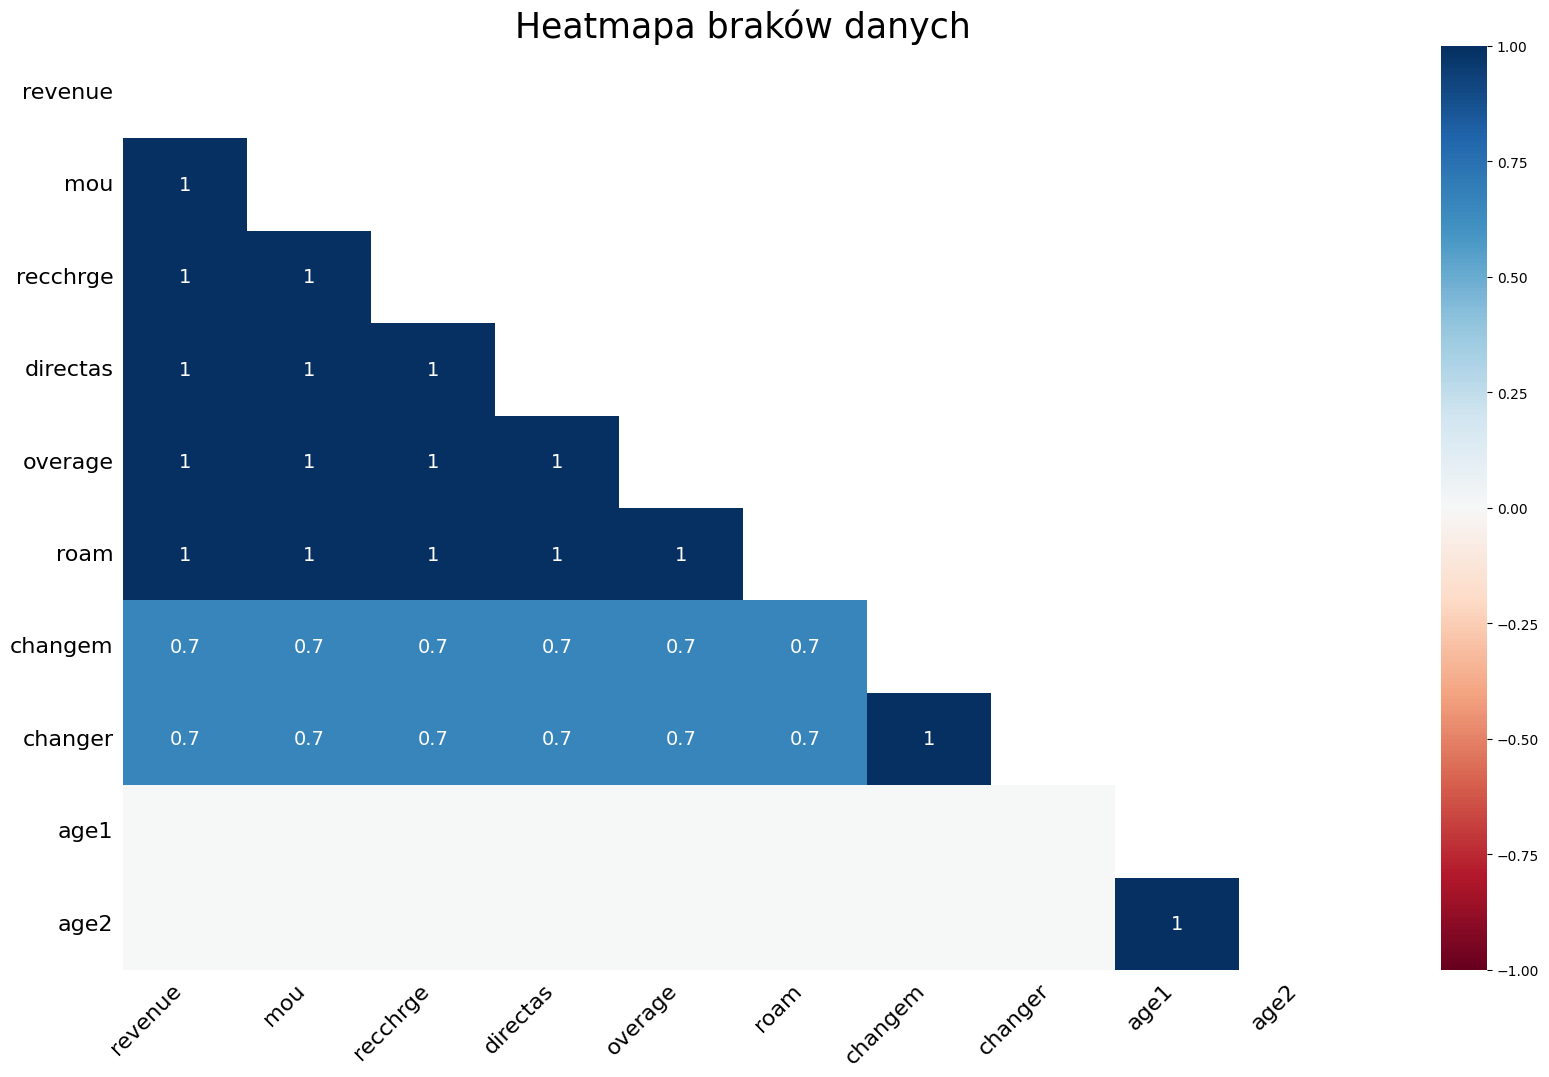

In [68]:
msno.heatmap(df.loc[:, df.isna().any()])
plt.title('Heatmapa braków danych',fontsize=25)

use knn imputer to imput missing values for the rest of columns
- roam - mean number of roaming calls
- revenue - mean monthly reve
- mou - mean monthly minutes of use
- reccharge - mean total recuring charge
- directas - Mean number of director assisted calls
- Overage - represents calls or minutes of use over the number of minutes allowed by that customer's calling plan.
- changem/changer - % Change in minutes of use/% Change in revenues
- agehh1
- agehh2

In [69]:
def evaluate_knn_imputation(df, max_k=8):
    # 1. Get a list of columns with NA in input df
    na_columns = df.columns[df.isna().any()].tolist()
    
    # 2. Drop NA's from the df
    df_clean = df.dropna()
    
    # 3. Create a random subset size of 50% of its original observations of df_clean
    subset_size = int(len(df_clean) * 0.5)
    df_subset = df_clean.sample(n=subset_size, random_state=1973)
    
    # 4. Set 200 random indexes which will later be inputted with NA's
    random.seed(1973)
    random_indexes = random.sample(range(subset_size), 200)
    
    # 5. Scaling the variables that do not have NA's
    scaler = StandardScaler()
    non_na_columns = [col for col in df_subset.columns if col not in na_columns]
    df_subset[non_na_columns] = scaler.fit_transform(df_subset[non_na_columns])
    
    results = []

    # 6. Loop through each column in na_columns
    for col in na_columns:
        print(col)
        # Copy the subset to not affect the original
        df_test = df_subset.copy()

        # 7. Input NA's for that column at the selected random indexes
        original_values = df_test.iloc[random_indexes][col].values
        df_test.loc[df_test.index[random_indexes], col] = np.nan
        
        # 8. Apply KNN imputation
        for k in range(1, max_k + 1):
            # Apply KNN imputation
            imputer = KNNImputer(n_neighbors=k)
            df_imputed = pd.DataFrame(imputer.fit_transform(df_test), columns=df_test.columns)
            
            # 9. Calculate MSE for the imputed column at the selected random indexes
            imputed_values = df_imputed.iloc[random_indexes][col].values
            mse = mean_squared_error(original_values, imputed_values)
            
            # 10. Store the results in the list
            results.append({'k': k, 'column': col, 'mse': mse})

    # 11. Convert the results list to a DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df

In [70]:
df_elbow=evaluate_knn_imputation(df,max_k=8)

revenue
mou
recchrge
directas
overage
roam
changem
changer
age1
age2


In [71]:
df_elbow=df_elbow.pivot(index='k',columns='column',values='mse').reset_index()

In [72]:
df_elbow

column,k,age1,age2,changem,changer,directas,mou,overage,recchrge,revenue,roam
0,1,521.160000,665.460000,71273.791110,805.326249,2.740128,163768.587283,5359.236737,277.452056,602.562600,20.573470
1,2,384.175000,528.530000,46735.868012,512.870238,2.934523,127350.425080,5048.041406,186.193416,355.422785,20.405950
2,3,345.748889,478.404444,42755.774972,506.988362,2.934227,111764.825149,3424.777523,162.281542,304.498411,19.171328
3,4,311.002500,394.297500,39507.749648,451.142996,2.456201,102968.938772,3305.250888,153.137820,330.840355,18.236198
4,5,314.032000,379.959200,33535.130347,408.362076,2.398262,103668.244036,3492.559626,143.500385,329.825096,18.418324
5,6,291.558889,355.154444,32229.820078,390.064322,2.092664,103683.341228,3721.644738,144.871891,309.104116,17.695323
6,7,300.175918,348.457143,31450.463732,363.505551,2.282958,103936.346996,3569.013896,140.714582,306.788989,17.333040
7,8,295.725625,340.526875,30669.347492,365.929669,2.125868,97444.611240,3777.159367,144.742856,295.283160,17.504246


In [73]:
def plot_elbow_method_results(wcss_df):
    # Number of columns to plot (excluding the 'k' column)
    columns_to_plot = wcss_df.columns.drop('k')
    num_columns = len(columns_to_plot)

    # Create a 2x5 grid (adjust based on the number of columns to plot)
    row_count=wcss_df.shape[1]-1
    fig, axes = plt.subplots(nrows=row_count, ncols=2, figsize=(10, 30))

    # Flatten axes for easy iteration
    axes = axes.flatten()

    for i, column in enumerate(columns_to_plot):
        if i >= len(axes):  # Just in case there are more columns than grid slots
            break
        
        # Plot WCSS for the current column
        axes[i].plot(wcss_df['k'], wcss_df[column], marker='o')
        axes[i].set_title(f'Metoda łokciowa dla {column}')
        axes[i].set_xlabel('Liczba sąsiadów (k)')
        axes[i].set_ylabel('błąd średniokwadroatowy')
    
    # Hide any remaining empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    # Adjust layout
    plt.tight_layout()
    plt.show()


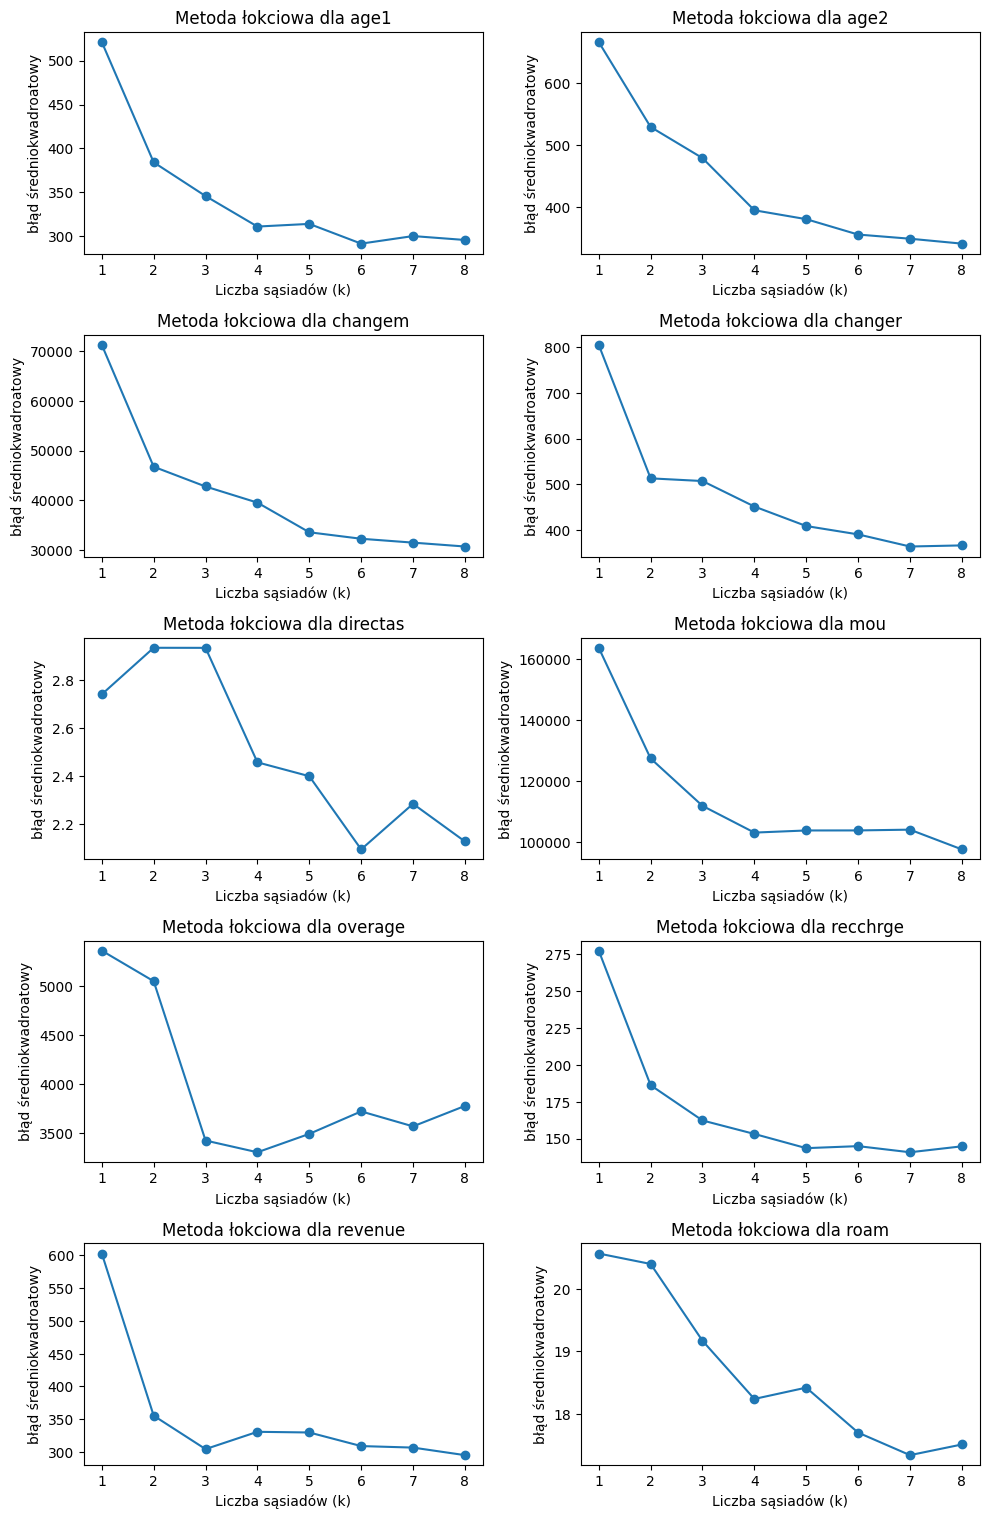

In [74]:
plot_elbow_method_results(df_elbow)

In [75]:
col_inputs = {
    'revenue': 5,
    'mou': 6,
    'recchrge': 3,
    'directas': 3,
    'overage': 3,
    'roam': 4,
    'changem': 4,
    'changer': 6,
    'age1': 4,
    'age2': 4}


In [76]:
def knn_impute_by_column(df, col_inputs):
    df_imputed = df.copy()  # Tworzymy kopię DataFrame, aby nie modyfikować oryginału
    
    for col, k in col_inputs.items():
        if col in df.columns:  # Sprawdzamy, czy kolumna istnieje w DataFrame
            # Tworzymy obiekt KNNImputer z podanym k
            imputer = KNNImputer(n_neighbors=k)
            scaler = StandardScaler()

            # Scale the column before imputing
            scaled_col = scaler.fit_transform(df_imputed[[col]])
            
            # Perform KNN imputation on the scaled data
            imputed_scaled_col = imputer.fit_transform(scaled_col)
            
            # Inverse transform the scaled imputed values back to the original scale
            imputed_col = scaler.inverse_transform(imputed_scaled_col)
            
            # Replace the original column with the imputed values (keeping other rows intact)
            df_imputed.loc[df_imputed[col].isna(), col] = imputed_col[df_imputed[col].isna()]
    
    return df_imputed
    # return df_imputed

In [77]:
df=knn_impute_by_column(df,col_inputs)

In [78]:
df.describe()

,churn,revenue,mou,recchrge,directas,overage,roam,changem,changer,dropvce,blckvce,unansvce,custcare,threeway,mourec,outcalls,incalls,peakvce,opeakvce,dropblk,callfwdv,callwait,months,uniqsubs,actvsubs,phones,models,eqpdays,age1,age2,children,credita,creditaa,prizmrur,prizmub,prizmtwn,refurb,webcap,truck,rv,occprof,occcler,occcrft,occstud,occhmkr,occret,occself,ownrent,marryun,marryyes,mailord,mailres,mailflag,travel,pcown,creditcd,retcalls,retaccpt,newcelly,newcelln,refer,incmiss,income,mcycle,setprcm,setprc,retcall
count,56836.000000,56836.000000,56836.000000,56836.000000,56836.000000,56836.000000,56836.000000,56836.000000,56836.000000,56836.000000,56836.000000,56836.000000,56836.000000,56836.000000,56836.000000,56836.000000,56836.000000,56836.000000,56836.000000,56836.000000,56836.000000,56836.000000,56836.000000,56836.000000,56836.000000,56836.000000,56836.000000,56836.000000,56836.000000,56836.000000,56836.000000,56836.000000,56836.000000,56836.000000,56836.000000,56836.000000,56836.000000,56836.000000,56836.000000,56836.000000,56836.000000,56836.000000,56836.000000,56836.000000,56836.000000,56836.000000,56836.000000,56836.000000,56836.000000,56836.000000,56836.000000,56836.000000,56836.000000,56836.000000,56836.000000,56836.000000,56836.000000,56836.000000,56836.000000,56836.000000,56836.000000,56836.000000,56836.000000,56836.000000,56836.000000,56836.000000,56836.000000
mean,0.290485,59.034272,527.506760,46.981982,0.897798,40.215320,1.229676,-10.881792,-1.208986,6.029609,4.074114,28.347277,1.868584,0.298174,115.385164,25.478300,8.228582,90.787057,67.876765,10.169397,0.013296,1.856919,18.741062,1.530280,1.352805,1.812689,1.565082,379.226476,31.321589,21.068731,0.242311,0.104318,0.129390,0.047822,0.319938,0.148462,0.139296,0.903441,0.187628,0.081181,0.174238,0.019671,0.029471,0.007601,0.003237,0.014093,0.017665,0.334084,0.385478,0.363836,0.360564,0.375748,0.014322,0.057446,0.185551,0.674731,0.036860,0.017735,0.192976,0.138645,0.050936,0.250317,4.325428,0.013407,0.565803,35.784767,0.033764
std,0.453990,44.250756,530.996606,23.961046,2.150611,96.665561,8.618042,255.995542,39.058590,9.047150,10.650532,38.775047,5.271005,1.140766,166.754513,35.285620,16.706509,105.177995,93.160569,15.345266,0.619158,5.484944,9.802250,0.869357,0.631252,1.346804,0.914101,253.801692,21.873163,23.658756,0.428485,0.305675,0.335634,0.213391,0.466456,0.355561,0.346258,0.295358,0.390418,0.273115,0.379317,0.138867,0.169123,0.086851,0.056806,0.117876,0.131731,0.471673,0.486712,0.481107,0.480168,0.484320,0.118815,0.232695,0.388748,0.468479,0.206509,0.141136,0.394638,0.345578,0.301124,0.433199,3.135465,0.115011,0.495655,56.924841,0.180622
min,0.000000,-6.167500,0.000000,-11.290000,0.000000,0.000000,0.000000,-3331.250000,-851.104981,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,1.000000,0.000000,1.000000,1.000000,-5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,33.722500,158.750000,30.000000,0.000000,0.000000,0.000000,-82.500000,-7.025625,0.666667,0.000000,5.333333,0.000000,0.000000,8.485000,3.333333,0.000000,23.250000,11.000000,1.666667,0.000000,0.000000,11.000000,1.000000,1.000000,1.000000,1.000000,204.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,48.896250,368.500000,44.990002,0.247500,2.750000,0.000000,-5.500000,-0.315000,3.000000,1.000

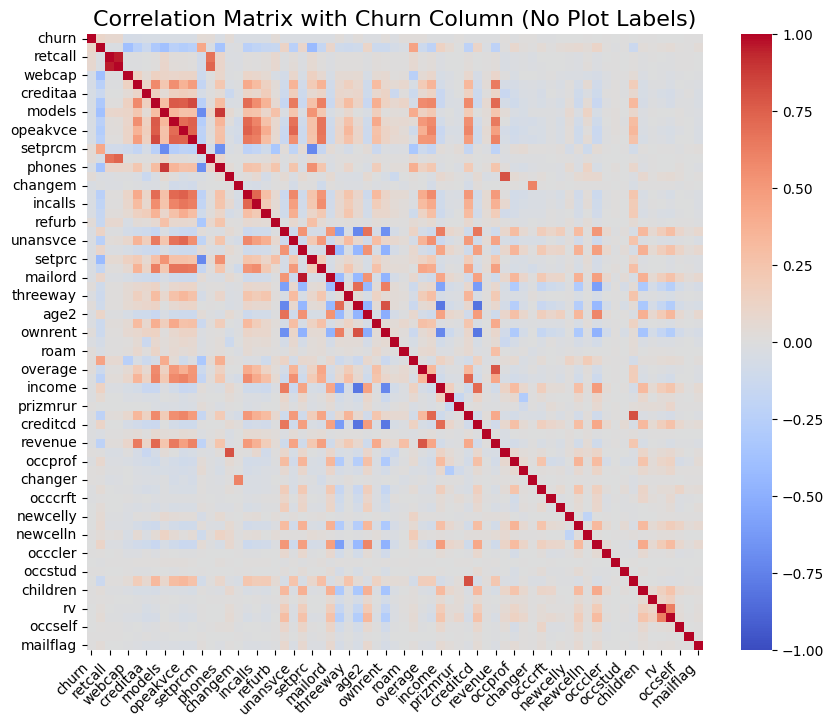

In [79]:
corr_matrix = df.corr()

# Extract the correlations involving the churn column and other variables that correlate with churn
columns_of_interest = corr_matrix['churn'].abs().sort_values(ascending=False).index
selected_corr_matrix = corr_matrix.loc[columns_of_interest, columns_of_interest]

# Plot the correlation matrix with variable labels but no axis labels
plt.figure(figsize=(10, 8))
sns.heatmap(selected_corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1, cbar=True, square=True)

# Remove axis labels but keep the variable labels
plt.title('Correlation Matrix with Churn Column (No Plot Labels)', fontsize=16)
plt.xlabel('')
plt.ylabel('')

# Adjust tick labels
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.show()

In [81]:
target_correlations = corr_matrix['churn']

# Identify features with correlation smaller than 0.01 (absolute value)
low_correlation_features = target_correlations[abs(target_correlations) < 0.01].index
df = df.drop(columns=low_correlation_features)

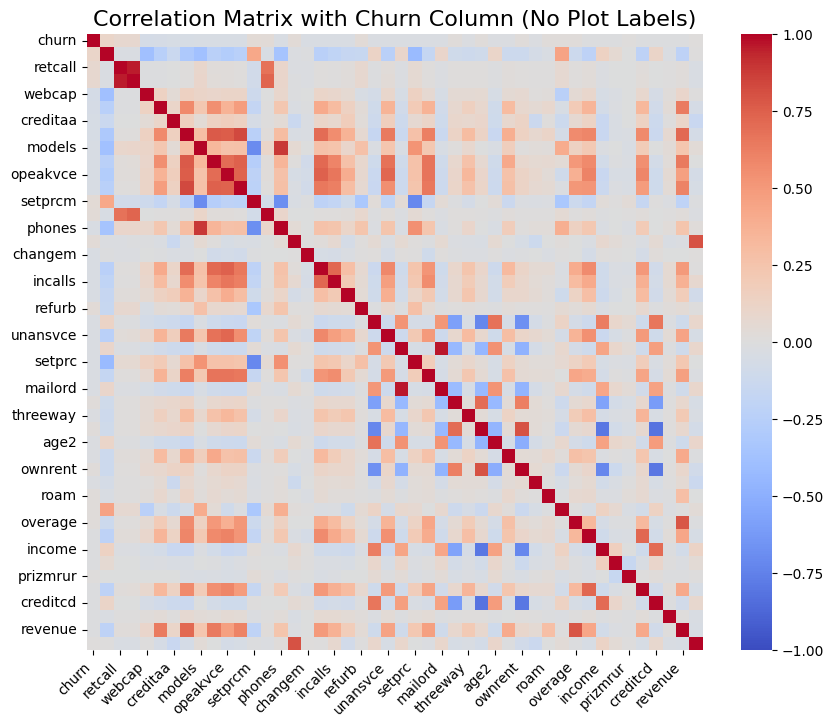

In [82]:
corr_matrix = df.corr()

# Extract the correlations involving the churn column and other variables that correlate with churn
columns_of_interest = corr_matrix['churn'].abs().sort_values(ascending=False).index
selected_corr_matrix = corr_matrix.loc[columns_of_interest, columns_of_interest]

# Plot the correlation matrix with variable labels but no axis labels
plt.figure(figsize=(10, 8))
sns.heatmap(selected_corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1, cbar=True, square=True)

# Remove axis labels but keep the variable labels
plt.title('Correlation Matrix with Churn Column (No Plot Labels)', fontsize=16)
plt.xlabel('')
plt.ylabel('')

# Adjust tick labels
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.show()

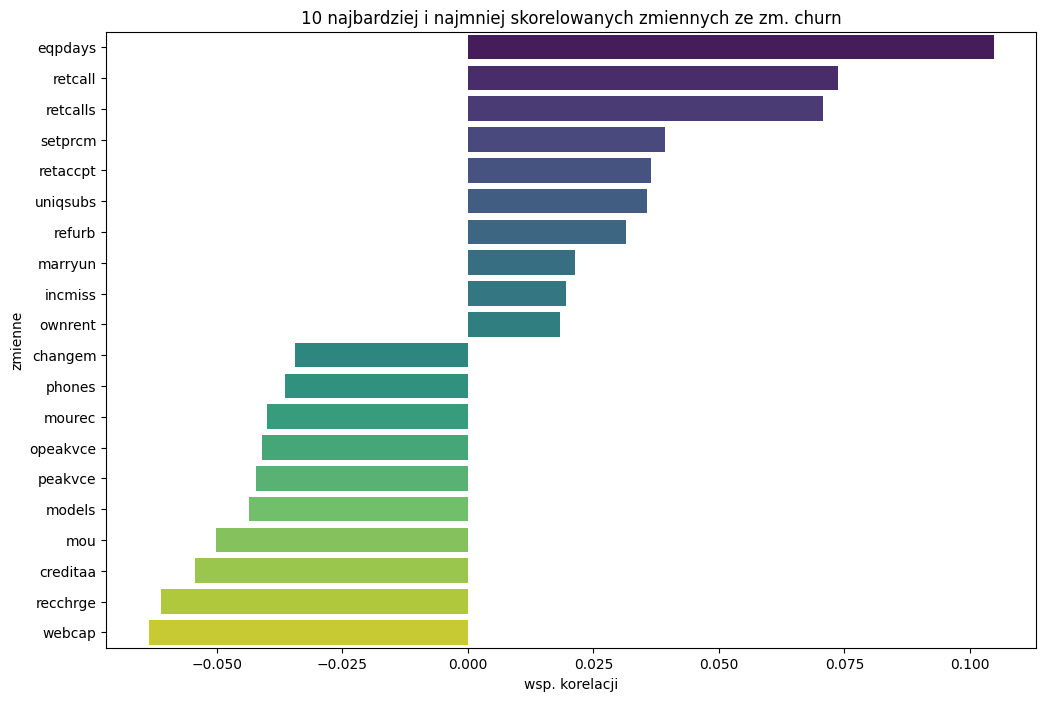

In [83]:
correlation_matrix = df.corr()
churn_correlation = correlation_matrix['churn'].sort_values()
most_correlated = churn_correlation.tail(11).head(10)  # Exclude the 'Churn' correlation with itself
least_correlated = churn_correlation.head(10)
combined_correlations = pd.concat([most_correlated, least_correlated]).sort_values(ascending=False)


plt.figure(figsize=(12, 8))
sns.barplot(x=combined_correlations.values, y=combined_correlations.index, palette='viridis')
plt.title('10 najbardziej i najmniej skorelowanych zmiennych ze zm. churn')
plt.xlabel('wsp. korelacji')
plt.ylabel('zmienne')
plt.show()

## modeling

How can we improve model? Depends what we aim for?

1. define the problem
1. Here choose a model metric we will be looking to optimise based on market reports and current tactics (google!)

1. EDA and approach to data cleaning manipulation
1. train test split target VAR description

1. Create base LR model to see how it performs
2. See how good can you make LR model by tuning hyperparameters training by using KFOLD / resampling train test and so on
    - we will have lots and lots of variables so using lasso/ ridge could turn out good explain them and see which parameter does the trick
    - adding variable combinations if possible and they make sense as a one way to improve a model
    - outline the advantages of LR such as interpretability of results coefficients and so on

3. ML Methods bagging XGB RandomForest
    - tweaking them by randomgridsearch/ gridsearch
    - train/test rebalancing by undersampling oversampling/ smooten
    - same methods as above 


#### LEVERAGE LIFT USE XD BECAUSE IT SOUNDS WELL

4. Neural network maybe? Idk about the volume of Prior work
5. Sum up the work which model performed better and so on. State that its dependent in use case and recommend using one based on this paper in this case and current trends.

In [84]:
pd.set_option('display.max_columns', None)

# Train Test Split


In [102]:
holdout_df=knn_impute_by_column(holdout_df,col_inputs)
holdout_df = holdout_df.drop(columns=low_correlation_features)

In [103]:
df['eqp_days_bucket'] = pd.qcut(df['eqpdays'], q=10, labels=False) + 1

bin_edges = pd.qcut(df['eqpdays'], q=10, retbins=True, duplicates='drop')[1]

# Step 2: Apply these bin edges to the holdout_df
holdout_df['eqp_days_bucket'] = pd.cut(holdout_df['eqpdays'], bins=bin_edges, labels=False, include_lowest=True) + 1

In [104]:
X_train = df.drop(columns=['churn'])
y_train = df['churn']

X_test = holdout_df.drop(columns=['churn'])
y_test = holdout_df['churn']

In [105]:
mean_values = df.mean()

holdout_df = holdout_df.fillna(mean_values)

## Baseline model

In [36]:
def evaluate_model(y_pred_proba, y_test, ret_df=False, plot_roc=False, name='model_name'):
    # Convert probabilities to class predictions based on a threshold of 0.5
    y_pred = (y_pred_proba[:, 1] >= 0.5).astype(int)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)  # Assuming 'Yes' is the positive class
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Calculate AUC
    auc = roc_auc_score(y_test, y_pred_proba[:,1])
    
    print(f"""Model Performance: 
    Accuracy = {round(accuracy*100, 3)}%
    Recall = {round(recall*100, 3)}%
    Precision = {round(precision*100, 3)}%
    F1 Score = {round(f1*100, 3)}%
    """)
    
    if plot_roc == True:
        # Plotting the ROC curve with different thresholds
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])
        plt.figure()
        plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {round(auc, 3)})')
        plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic - {name}')
        plt.legend(loc="lower right")
        print(f'AUC = {round(auc*100, 3)}%')

        # # Annotate the thresholds
        # for i in range(len(thresholds)):
        #     plt.annotate(f'{round(thresholds[i], 2)}', 
        #                 xy=(fpr[i], tpr[i]), 
        #                 textcoords='offset points', 
        #                 xytext=(0, 10), 
        #                 ha='center')
        
    plt.show()

    if ret_df:
        metrics = {
            'model': [name],
            'Accuracy': [accuracy],
            'Recall': [recall],
            'Precision': [precision],
            'F1 Score': [f1],
            'AUC': [auc]
        }
        return pd.DataFrame(metrics)

In [107]:
def simple_eval(y_pred, y_test, ret_df=False, name='model_name'):
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)  # Assuming 'Yes' is the positive class
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Calculate AUC
    auc = roc_auc_score(y_test, y_pred)
    
    print(f"""Model Performance: 
    Accuracy = {round(accuracy*100, 3)}%
    Recall = {round(recall*100, 3)}%
    Precision = {round(precision*100, 3)}%
    F1 Score = {round(f1*100, 3)}%
    AUC = {round(auc*100, 3)}%
    """)

    if ret_df:
        metrics = {
            'model': [name],
            'Accuracy': [accuracy],
            'Recall': [recall],
            'Precision': [precision],
            'F1 Score': [f1],
            'AUC': [auc]
        }
        return pd.DataFrame(metrics)

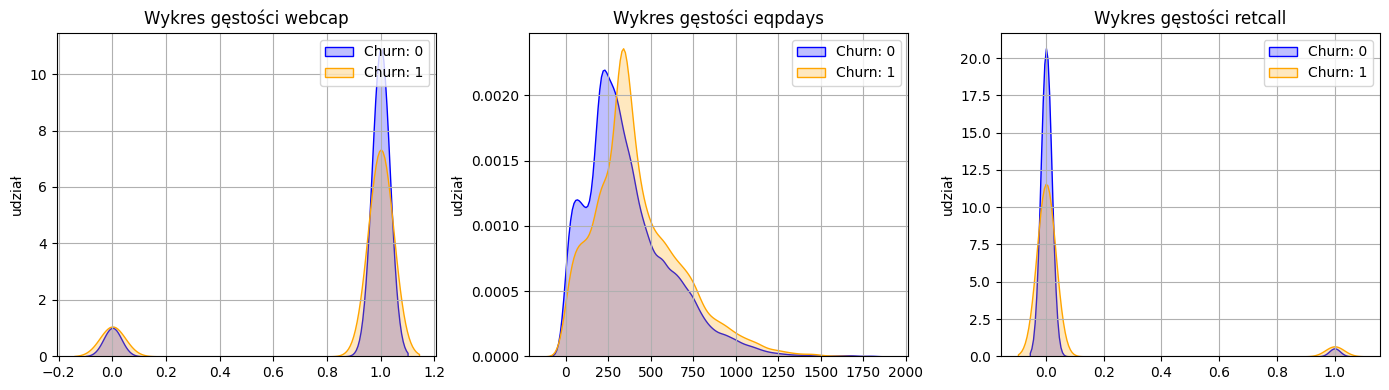

In [108]:
plot_eda_density(['webcap','eqpdays','retcall'],num_cols=3)

In [109]:
y_pred_base = pd.DataFrame()

In [110]:
y_pred_base['y_pred'] = (
    (X_train['eqpdays'] >= 350) |
    (X_train['webcap'] == 0) |
    (X_train['retcall'] == 1)
).astype(int)

In [111]:
simple_eval(y_pred_base,y_train,ret_df=True,name='baseline_kmeans')

Model Performance: 
    Accuracy = 55.426%
    Recall = 58.183%
    Precision = 34.263%
    F1 Score = 43.128%
    AUC = 56.24%
    


,model,Accuracy,Recall,Precision,F1 Score,AUC
0,baseline_kmeans,0.554261,0.581829,0.342631,0.431285,0.562402


In [112]:
y_test_base_pred=pd.DataFrame()

In [113]:
y_test_base_pred['y_pred'] = (
    (X_test['eqpdays'] >= 350) |
    (X_test['webcap'] == 0) |
    (X_test['retcall'] == 1)
).astype(int)

In [114]:
simple_eval(y_test_base_pred,y_test,ret_df=True,name='baseline_kmeans')

Model Performance: 
    Accuracy = 55.095%
    Recall = 59.673%
    Precision = 34.095%
    F1 Score = 43.396%
    AUC = 56.456%
    


,model,Accuracy,Recall,Precision,F1 Score,AUC
0,baseline_kmeans,0.55095,0.596731,0.340953,0.433957,0.564561


# KFOLD

In [115]:
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=1973)

In [116]:
scoring = make_scorer(f1_score, average='weighted')  # Adjust 'average' depending on your problem

# XGB

In [117]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')

# Train the model on the training data
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [118]:
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb=xgb_model.predict_proba(X_test)

Model Performance: 
    Accuracy = 71.224%
    Recall = 19.615%
    Precision = 50.313%
    F1 Score = 28.225%
    
AUC = 65.753%


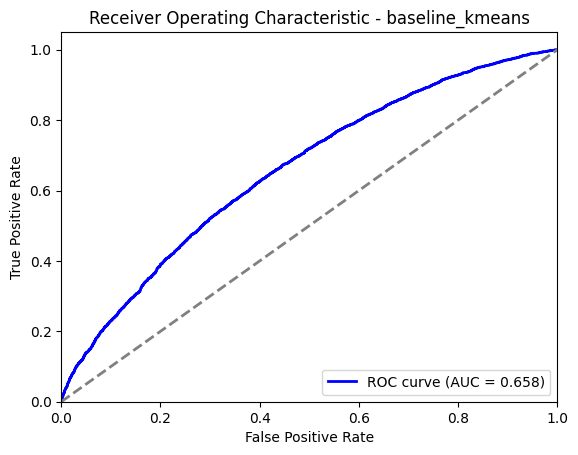

,model,Accuracy,Recall,Precision,F1 Score,AUC
0,baseline_kmeans,0.712245,0.196145,0.503129,0.282254,0.657534


In [119]:
evaluate_model(y_proba_xgb,y_test,ret_df=True,plot_roc=True,name='baseline_kmeans')

In [120]:
# Hyperparameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': np.arange(50, 300, 50),
    'max_depth': np.arange(3, 10),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': np.linspace(0, 0.5, 5)
}

In [121]:
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=20,  # Number of different combinations to try
    scoring=scoring,
    cv=stratified_kfold,
    verbose=1,
    n_jobs=-1,  # Use all available cores
    random_state=1973
)

In [122]:
# Fit the model
random_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print(f"Best parameters found: {random_search.best_params_}")
print(f"Best F1 Score from cross-validation: {random_search.best_score_}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters found: {'subsample': 0.9, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.20333333333333334, 'gamma': 0.0, 'colsample_bytree': 0.6}
Best F1 Score from cross-validation: 0.667899472285768


In [123]:
# Predict on the test set with the best found model
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba=best_model.predict_proba(X_test)

Test F1 Score: 0.6634796909442052


Model Performance: 
    Accuracy = 71.232%
    Recall = 19.029%
    Precision = 50.355%
    F1 Score = 27.62%
    
AUC = 65.837%


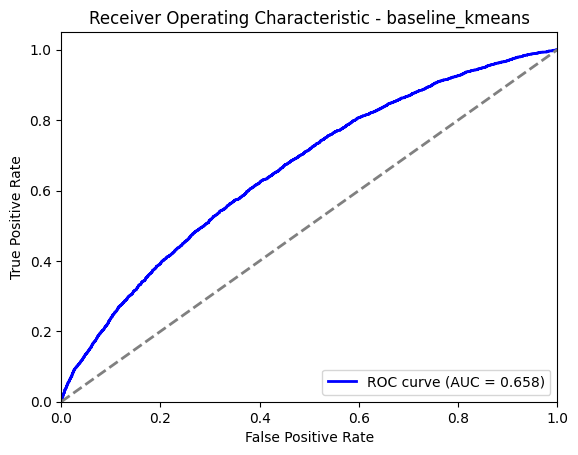

,model,Accuracy,Recall,Precision,F1 Score,AUC
0,baseline_kmeans,0.712315,0.19029,0.503551,0.276204,0.658365


In [124]:
evaluate_model(y_pred_proba,y_test,ret_df=True,plot_roc=True,name='baseline_kmeans')

In [125]:
best_params = random_search.best_params_

# Define the grid based on the best parameters from the random search
param_grid = {
    'n_estimators': np.arange(max(50, best_params['n_estimators'] - 50), best_params['n_estimators'] + 100, 50),
    'max_depth': np.arange(max(3, best_params['max_depth'] - 2), best_params['max_depth'] + 3),
    'learning_rate': np.linspace(max(0.01, best_params['learning_rate'] * 0.8), min(0.3, best_params['learning_rate'] * 1.2), 3),
    'subsample': np.clip([best_params['subsample'] * 0.9, best_params['subsample'], best_params['subsample'] * 1.1], 0.6, 1.0),
    'colsample_bytree': np.clip([best_params['colsample_bytree'] * 0.9, best_params['colsample_bytree'], best_params['colsample_bytree'] * 1.1], 0.6, 1.0),
    'gamma': np.linspace(max(0, best_params['gamma'] * 0.8), min(0.5, best_params['gamma'] * 1.2), 3)
}

# Instantiate the GridSearchCV object
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring=scoring,
    cv=stratified_kfold,
    verbose=1,
    n_jobs=-1,  # Use all available cores
)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best model and predictions
best_grid_model = grid_search.best_estimator_
y_grid_pred = best_grid_model.predict(X_test)
y_grid_pred_proba = best_grid_model.predict_proba(X_test)

Fitting 3 folds for each of 1215 candidates, totalling 3645 fits


KeyboardInterrupt: 

In [ ]:
evaluate_model(y_grid_pred_proba,y_test,ret_df=True,plot_roc=True,name='baseline_kmeans')

# RANDOM FOREST

In [126]:
rf_model = RandomForestClassifier(random_state=1973)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=1973)

In [127]:
y_pred_proba_rf = rf_model.predict_proba(X_test)

Model Performance: 
    Accuracy = 71.865%
    Recall = 11.759%
    Precision = 55.852%
    F1 Score = 19.428%
    
AUC = 64.936%


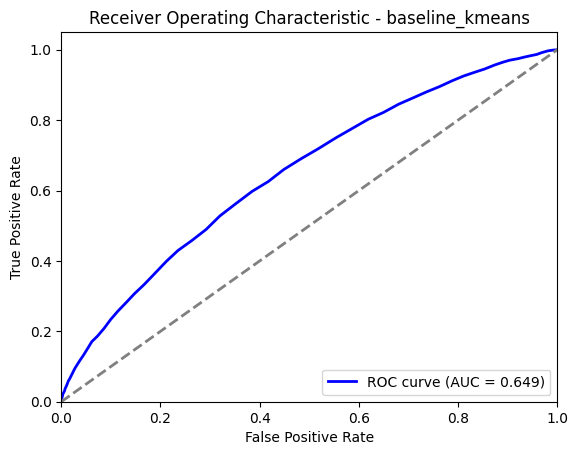

,model,Accuracy,Recall,Precision,F1 Score,AUC
0,baseline_kmeans,0.718649,0.11759,0.558517,0.194277,0.649362


In [128]:
evaluate_model(y_pred_proba_rf,y_test,ret_df=True,plot_roc=True,name='baseline_kmeans')

In [ ]:
base_grid_rf = {
    'n_estimators': np.arange(100, 1100, 200),
    'max_depth': np.arange(10, 50, 10),
    'min_samples_split': np.arange(2, 10, 2),
    'min_samples_leaf': np.arange(1, 5, 1),
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}


# Initialize GridSearchCV with the base grid
grid_search_rf = RandomizedSearchCV(
    estimator=rf_model,
    param_grid=base_grid_rf,
    scoring='f1',  # or use your preferred scoring metric
    cv=stratified_kfold,
    verbose=1,
    n_jobs=-1,  # Use all available cores
    random_state=1973
)

# Fit the grid search
grid_search_rf.fit(X_train, y_train)

# Get the best parameters from the grid search
best_params_from_grid = grid_search_rf.best_params_

# Evaluate the best model from grid search
y_pred_proba_rf_grid = grid_search_rf.best_estimator_.predict_proba(X_test)


In [ ]:
evaluate_model(y_pred_proba_rf_grid,y_test,ret_df=True,plot_roc=True,name='baseline_kmeans')

In [ ]:
# Expanded grid based on best parameters from the first grid search
refined_grid_rf = {
    'n_estimators': np.unique(np.arange(max(100, best_params_from_grid['n_estimators'] - 200), best_params_from_grid['n_estimators'] + 400, 100)),
    'max_depth': np.unique(np.arange(max(10, best_params_from_grid['max_depth'] - 10), min(50, best_params_from_grid['max_depth'] + 20), 4)),
    'min_samples_split': np.unique(np.arange(max(2, best_params_from_grid['min_samples_split'] - 2), best_params_from_grid['min_samples_split'] + 4, 1)),
    'min_samples_leaf': np.unique(np.arange(max(1, best_params_from_grid['min_samples_leaf'] - 1), best_params_from_grid['min_samples_leaf'] + 2, 1)),
    'max_features': [best_params_from_grid['max_features']],
    'bootstrap': [best_params_from_grid['bootstrap']]
}

# Initialize GridSearchCV with the refined grid
refined_grid_search_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=refined_grid_rf,
    scoring='f1',  # or your preferred scoring metric
    cv=stratified_kfold,
    verbose=1,
    n_jobs=-1,  # Use all available cores
    random_state=1973
)

# Fit the refined grid search
refined_grid_search_rf.fit(X_train, y_train)

# Evaluate the best model from the refined grid search
best_model_rf = refined_grid_search_rf.best_estimator_
y_pred_proba_rf_refined_grid = best_model_rf.predict_proba(X_test)

In [ ]:
evaluate_model(y_pred_proba_rf_refined_grid,y_test,ret_df=True,plot_roc=True,name='baseline_kmeans')

## Linear Regrssion model

In [129]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)
y_pred = model_lr.predict(X_test)
y_proba_lr = model_lr.predict_proba(X_test)

C:\Users\xtaym\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model Performance: 
    Accuracy = 70.992%
    Recall = 0.39%
    Precision = 29.091%
    F1 Score = 0.77%
    
AUC = 56.978%


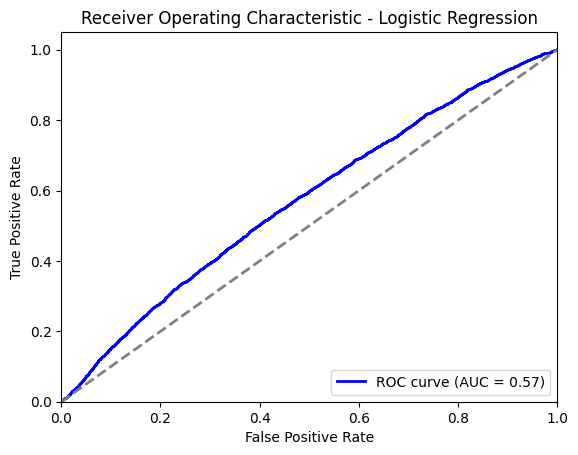

In [130]:
evaluate_model(y_proba_lr, y_test, name='Logistic Regression', plot_roc=True, ret_df=False)

In [131]:
logistic_reg = LogisticRegression(penalty='l1', solver='saga', max_iter=1000, random_state=1973)
# penalty='elasticnet'
# Define a grid of alpha (C) and l1_ratio values
param_grid = {
    'C': [0.01, 0.1, 1, 10],  # C is the inverse of regularization strength; smaller values specify stronger regularization
    # 'l1_ratio': [0.1, 0.5 , 0.9]  # Mix ratio for L1 and L2 regularization
}

# Use GridSearchCV to find the best C and l1_ratio
grid_search = RandomizedSearchCV(
  logistic_reg, param_grid, cv=stratified_kfold, scoring=scoring,
  random_state=1973,n_jobs=-1,verbose=1)
grid_search.fit(X_train, y_train)

C:\Users\xtaym\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\xtaym\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=1973, shuffle=True),
                   estimator=LogisticRegression(max_iter=1000, penalty='l1',
                                                random_state=1973,
                                                solver='saga'),
                   n_jobs=-1, param_distributions={'C': [0.01, 0.1, 1, 10]},
                   random_state=1973,
                   scoring=make_scorer(f1_score, average=weighted), verbose=1)

In [132]:
# Retrieve the best model and best parameters
best_logistic_net_model = grid_search.best_estimator_
print("Best parameters for Elastic Net Logistic Regression:", grid_search.best_params_)

# Evaluate the best model on the test set
y_pred = best_logistic_net_model.predict(X_test)
y_pred_proba = best_logistic_net_model.predict_proba(X_test)  # Probability estimates for the positive class

Best parameters for Elastic Net Logistic Regression: {'C': 0.01}


Model Performance: 
    Accuracy = 70.957%
    Recall = 0.342%
    Precision = 25.0%
    F1 Score = 0.674%
    
AUC = 57.361%


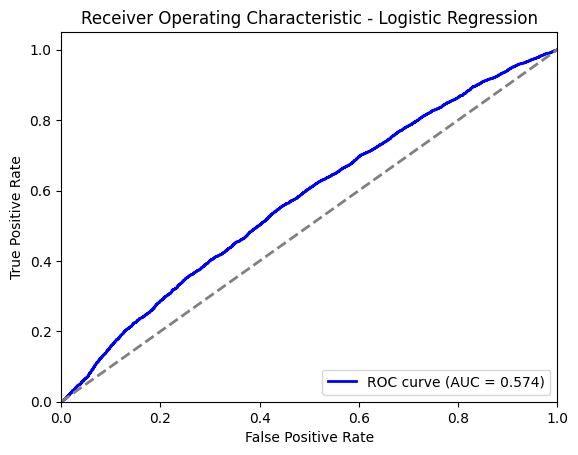

In [135]:
evaluate_model(y_pred_proba, y_test, name='Logistic Regression', plot_roc=True, ret_df=False)

In [136]:
def train_and_evaluate_by_bucket(X_train, y_train, X_test, y_test, model):
    models = {}
    results = []

    for bucket in sorted(X_train.eqp_days_bucket.unique(), reverse=True):
        # Filter the training data for the current bucket
        X_train_bucket = X_train[X_train.eqp_days_bucket == bucket]
        y_train_bucket = y_train[X_train.eqp_days_bucket == bucket]
        
        # Train the provided model for this bucket
        model_clone = model.__class__(**model.get_params())  # Clone the model to avoid reusing the same instance
        model_clone.fit(X_train_bucket, y_train_bucket)
        
        # Store the trained model in the dictionary
        models[bucket] = model_clone
        
        # Now evaluate on the corresponding bucket in the test data
        X_test_bucket = X_test[X_test.eqp_days_bucket == bucket]
        y_test_bucket = y_test[X_test.eqp_days_bucket == bucket]
        
        # Predict and evaluate accuracy and AUC for this bucket
        y_pred = model_clone.predict(X_test_bucket)
        y_pred_proba = model_clone.predict_proba(X_test_bucket)[:, 1] if hasattr(model_clone, "predict_proba") else y_pred
        
        accuracy = accuracy_score(y_test_bucket, y_pred)
        auc = roc_auc_score(y_test_bucket, y_pred_proba)
        
        # Append the results to the list
        results.append({'Bucket': bucket, 'Accuracy': accuracy, 'AUC': auc})
    
    # Create a DataFrame from the results and sort by Bucket number descending
    results_df = pd.DataFrame(results).sort_values(by='Bucket', ascending=False).reset_index(drop=True)
    
    return models, results_df

# Instantiate your model (can be any model like LogisticRegression, RandomForestClassifier, etc.)
model = LogisticRegression()

# Call the function with the model as an argument
models, results_df = train_and_evaluate_by_bucket(X_train, y_train, X_test, y_test, model)

# Display the results DataFrame
print(results_df)

C:\Users\xtaym\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\xtaym\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

   Bucket  Accuracy       AUC
0      10  0.630748  0.546873
1       9  0.671159  0.576784
2       8  0.691332  0.527522
3       7  0.688223  0.579812
4       6  0.600832  0.582239
5       5  0.682551  0.586185
6       4  0.804842  0.574615
7       3  0.810945  0.588416
8       2  0.737029  0.544762
9       1  0.793844  0.588190


C:\Users\xtaym\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\xtaym\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

In [137]:
results_df

,Bucket,Accuracy,AUC
0,10,0.630748,0.546873
1,9,0.671159,0.576784
2,8,0.691332,0.527522
3,7,0.688223,0.579812
4,6,0.600832,0.582239
5,5,0.682551,0.586185
6,4,0.804842,0.574615
7,3,0.810945,0.588416
8,2,0.737029,0.544762
9,1,0.793844,0.588190


In [ ]:
proba=model_lr.predict_proba(X_test)

In [ ]:

def test_thresh(x,y_test):
    threshold_value=[]
    scores_acc=[]
    scores_f1=[]
    scores_rec=[]
    scores_prec=[]
    scores_auc=[]
    for i in np.linspace(0, 1, 101):
        threshold = i  # You can adjust the threshold as needed
        y_pred_fun = (x[:, 1] > threshold).astype(int)
        threshold_value.append(i)
        scores_acc.append(accuracy_score(y_test, y_pred_fun))
        scores_f1.append(f1_score(y_test, y_pred_fun))
        scores_rec.append(recall_score(y_test, y_pred_fun))
        scores_prec.append(precision_score(y_test, y_pred_fun))
        scores_auc.append(roc_auc_score(y_test, y_pred_fun))

        #scores_roc.append(roc_auc_score(y_test, y_prob))
    return pd.DataFrame({'threshold_value':threshold_value,'score_acc':scores_acc,'score_f1':scores_f1,'score_rec':scores_rec,'score_prec':scores_prec,'auc':scores_auc}).set_index('threshold_value')

C:\Users\xtaym\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\xtaym\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\xtaym\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill

<Axes: xlabel='threshold_value'>

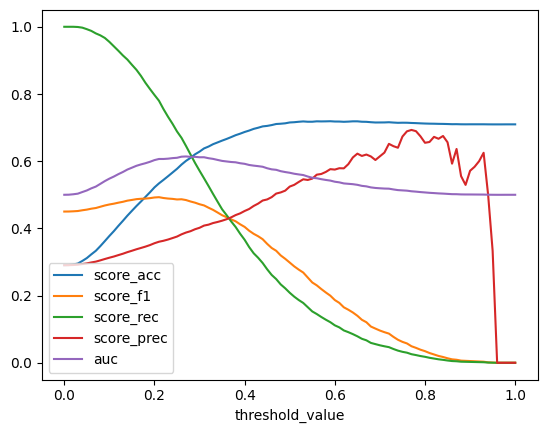

In [ ]:
test_thresh(y_pred_proba,y_test).plot()

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, y_proba_lr[:,0])
average_precision = average_precision_score(y_test, y_proba_lr[:,0])